# Проект: Маркетинг.

## Описание проекта.

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи.<br/>
Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

### Описание данных.

**apparel-purchases история покупок**<br/><br/>
Данные о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук.<br/>
В таблице есть списки идентификаторов, к каким категориям относится товар. Часто это вложенные категории (например автотовары-аксессуары-освежители), но также может включать в начале списка маркер распродажи или маркер женщинам/мужчинам.<br/>
Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594']. Как обработать такие случаи – можно предлагать свои варианты решения.<br/>
- client_id идентификатор пользователя/клиента
- quantity количество товаров в заказе
- price цена товара
- category_ids вложенные категории, к которым отнсится товар (идентификаторы категорий)
- date дата покупки
- message_id идентификатор сообщения из рассылки<br/><br/>

**apparel-messages история рекламных рассылок**<br/><br/>
Рассылки, которые были отправлены клиентам из таблицы покупок.<br/>
- bulk_campaign_id идентификатор рекламной кампании (рассылки)
- client_id идентификатор пользователя/клиента
- message_id идентификатор сообщений
- event тип действия, действие с сообщением (отправлено, открыто, покупка...)
- channel канал рассылки
- date дата рассылки
- created_at точное время создания сообщения<br/><br/>

**target**<br/>
- client_id идентификатор клиента
- target клиент совершил покупку в целевом периоде<br/><br/>

**full_campaign_daily_event агрегация общей базы рассылок по дням и типам событий**<br/><br/>
Общая база рассылок огромна, поэтому собрана агрегированная по дням статистика по рассылкам.<br/>
Если будем создавать на основе этой статистики дополнительные признаки, необходимо обратить внимание, что нельзя суммировать по колонкам nunique, потому что это уникальные клиенты в пределах дня, у нас нет данных, повторяются ли они в другие дни.<br/>
- date дата
- bulk_campaign_id идентификатор рассылки
- count_event* общее количество каждого события event
- nunique_event* количество уникальных client_id в каждом событии<br/>
###### * в именах колонок найдете все типы событий event<br/><br/>

**full_campaign_daily_event_channel агрегация по дням с учетом событий и каналов рассылки**<br/>
- date дата
- bulk_campaign_id идентификатор рассылки
- count_event*_channel* общее количество каждого события по каналам
- nunique_event*_channel* количество уникальных client_id по событиям и каналам<br/>
###### * в именах колонок есть все типы событий event и каналов рассылки channel

### Предварительный план.

- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей    
- Улучшить модель и максимизировать метрику roc_auc
- Выполнить тестирование

**Базовая цель проекта.**

Предсказать вероятность покупки в течение 90 дней.

## Загрузка данных.

### Загрузка библиотек.

In [2684]:
try:
    # Установка всех зависимостей из requirements.txt
    %pip install -r requirements.txt -q
except Exception as error:
    print(f'Ошибка загрузки: {error}')

Note: you may need to restart the kernel to use updated packages.


In [2685]:
try:
    import ast
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import shap
    import warnings
    from catboost import CatBoostClassifier
    from datetime import timedelta
    from scipy import stats as st
    from phik import phik_matrix
    from sklearn.compose import ColumnTransformer
    from sklearn.dummy import DummyClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.impute import SimpleImputer
    from sklearn.linear_model import LogisticRegression 
    # from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier # , DecisionTreeRegressor
    # from sklearn.svm import SVC
    from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
    from sklearn.metrics import (
        accuracy_score,
        confusion_matrix,
        roc_auc_score,
        recall_score,
        precision_score,
        f1_score)
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import (
        OneHotEncoder,
        OrdinalEncoder,
        # LabelEncoder,
        MinMaxScaler,
        StandardScaler)
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    from statsmodels.tools.tools import add_constant
except ImportError as error:
    print(f'Ошибка импорта: {error}')

### Константы.

In [2686]:
ZERO = 0
ONE = 1
TWO = 2
# THREE = 3
FIVE = 5
SIX = 6
TEN = 10
ID = 'client_id'
RANDOM_STATE = 42
TEST_SIZE = 0.25
# COLOR_ONE = 'SteelBlue'
# COLOR_TWO = 'Yellow'
# COLOR_THREE = 'Green'
# COLOR_FOUR = 'Blues'
PATH = 'datasets/'

### Загрузка данных из csv-файлов в датафрейм.

In [2687]:
try:
    messages = pd.read_csv(f'{PATH}apparel-messages.csv')
    purchases = pd.read_csv(f'{PATH}apparel-purchases.csv')
    target = pd.read_csv(f'{PATH}apparel-target_binary.csv')
    event = pd.read_csv(f'{PATH}full_campaign_daily_event.csv')    
    event_chanel = pd.read_csv(f'{PATH}full_campaign_daily_event_channel.csv')
except FileNotFoundError:
    print(f'Что то пошло не так: {error}')

### Дополнительные настройки.

In [2688]:
# Отключаем предупреждения.
pd.options.mode.chained_assignment = None

# Задаем два знака после запятой для чисел с плавающей запятой.
pd.options.display.float_format = '{:,.2f}'.format

# Игнорирование предупреждений.
warnings.filterwarnings('ignore')

# Установка опции для отображения максимальной ширины столбца.
pd.set_option('display.max_colwidth', None)

### Вспомогательные методы.

In [2689]:
# Добавим имена датафреймов в список.
data_names = ['messages', 'purchases', 'target', 'event', 'event_chanel']

In [2690]:
# Кастомный метод вывода информации о датафрейме.
def custom_info(value,
                name='',
                dtype_recom=False,
                is_result=True,
                sample=False,
                sample_quantity=TEN,
                head_value=0):
    result = (
        pd.DataFrame(value.count(),
                     columns=['non_null_count']))
    result['dtype'] = (
        pd.DataFrame(value.dtypes, 
                     columns=['dtype']))

    if name:
        print(f'\nСтатистика по столбцам, выборка {name}.')

    if dtype_recom:
        result['dtype_recomended'] = (
            pd.DataFrame(
                value.convert_dtypes()
                .dtypes.to_frame()
                .rename(columns={0: 'dtype_recomended'}), 
                        columns=['dtype_recomended']))

    if is_result:
        display(result)
    print(f'Количество записей: {len(value)}')
    print(f'Количество столбцов: {len(value.columns)}')

    if sample:
        display(value.sample(sample_quantity).T)

    if head_value != 0:
        display(value.head(head_value).T)

In [2691]:
# Проверка пустых значений в датафрейме.
def count_none_values_table(value, name=''):
    try:
        result = (
            (value.isna().sum())
            .to_frame()
            .rename(columns={0: 'count_none'})
            .query('count_none > 0'))
        if len(result) != 0:
            print(f'Пропущенные значения в датафрейме {name}.'.strip())
            display(result.sort_values(by='count_none', ascending=True))
        else:
            print(f'В датафрейме {name} нет пропущенных значений.'
                  .replace('  ', ' '))
    except Exception as error:
        print(f'Что пошло не так: {error}')

### Общая информация о полученных датафреймах.

Посмотрим на статистику по столбцам.<br/>
Выведем на экран по 10 случайных позиций данных из каждого датафрейма. Посмотрим на их состав.

In [2692]:
for name in data_names:
    if name in locals():
        custom_info(locals()[name], name, sample=True)
    else:
        print(f'Датафрейм {name} не найден!')


Статистика по столбцам, выборка messages.


,non_null_count,dtype
bulk_campaign_id,12739798,int64
client_id,12739798,int64
message_id,12739798,object
event,12739798,object
channel,12739798,object
date,12739798,object
created_at,12739798,object


Количество записей: 12739798
Количество столбцов: 7


,2161716,11904563,533956,4060814,5549862,7785831,2561964,9520079,8048697,2465688
bulk_campaign_id,7407,14529,5184,10218,13249,13831,7845,14150,13868,7820
client_id,1515915625488307111,1515915625503248058,1515915625559566500,1515915625488706427,1515915625912686868,1515915625790511105,1515915625501972226,1515915625624694126,1515915625986540450,1515915625642847704
message_id,1515915625488307111-7407-635b7ab032bda,1515915625503248058-14529-65b0af1818ace,1515915625559566500-5184-62bc0358aac17,1515915625488706427-10218-63ef56edd9a76,1515915625912686868-13249-6481b8ee68a50,1515915625790511105-13831-65054a353a2df,1515915625501972226-7845-6373359711b44,1515915625624694126-14150-655c47edd46b7,1515915625986540450-13868-6513cc29af8c3,1515915625642847704-7820-6370c04222a69
event,send,send,send,send,send,click,click,open,send,open
channel,email,mobile_push,email,email,mobile_push,email,email,mobile_push,email,mobile_push
date,2022-10-28,2024-01-24,2022-06-29,2023-02-17,2023-06-08,2023-09-16,2022-11-16,2023-11-21,2023-09-27,2022-11-13
created_at,2022-10-28 08:31:55,2024-01-24 07:35:55,2022-06-29 09:05:45,2023-02-17 10:31:21,2023-06-08 13:29:43,2023-09-16 17:32:11,2022-11-16 05:45:24,2023-11-21 08:24:45,2023-09-27 08:59:15,2022-11-13 10:51:20



Статистика по столбцам, выборка purchases.


,non_null_count,dtype
client_id,202208,int64
quantity,202208,int64
price,202208,float64
category_ids,202208,object
date,202208,object
message_id,202208,object


Количество записей: 202208
Количество столбцов: 6


,139951,10017,24425,187277,181389,64359,176725,25761,126995,42414
client_id,1515915625490833454,1515915625470689537,1515915625564461881,1515915625475742203,1515915625758476585,1515915625872689866,1515915625555279309,1515915625558735628,1515915625575863859,1515915625619437352
quantity,1,1,1,1,1,1,1,1,1,1
price,512.00,"2,499.00",799.00,"2,634.00",529.00,"3,899.00",699.00,"1,499.00",310.00,66.00
category_ids,"['5562', '5633', '5611', '713']","['4', '28', '260', '420']","['5562', '5630', '5592', '676']","['5562', '5589', '5610', '1635']","['4', '29', '309', '939']","['4', '31', '324', '466']","['5562', '5630', '5607', '555']","['4', '28', '340', '1312']","['4', '31', '326', '505']","['5562', '5633', '5627', '573']"
date,2023-06-15,2022-06-04,2022-07-16,2023-12-25,2023-12-06,2022-12-14,2023-11-10,2022-07-22,2023-06-02,2022-11-04
message_id,1515915625490833454-13353-648adf79ad023,1515915625491498199-4679-6297221e102dc,1515915625564461881-5335-62c7d2c8ac616,1515915625475742203-14359-6587f2aec5ccd,1515915625758476585-14251-65702d93b5ac9,1515915625487760249-8504-6392e450c173d,1515915625764186724-14081-654db9441a35e,1515915625558735628-5559-62da4ea7a8323,1515915625938601832-13076-6479c497a8636,1515915625619437352-7576-636375236ec95



Статистика по столбцам, выборка target.


,non_null_count,dtype
client_id,49849,int64
target,49849,int64


Количество записей: 49849
Количество столбцов: 2


,21051,17721,4254,37706,2527,23839,5966,19167,20696,23035
client_id,1515915625503416820,1515915625491913424,1515915625474792240,1515915625637550888,1515915625468267004,1515915625550073180,1515915625487251406,1515915625500618314,1515915625502840147,1515915625544120902
target,0,0,0,0,0,0,0,0,0,0



Статистика по столбцам, выборка event.


,non_null_count,dtype
date,131072,object
bulk_campaign_id,131072,int64
count_click,131072,int64
count_complain,131072,int64
count_hard_bounce,131072,int64
count_open,131072,int64
count_purchase,131072,int64
count_send,131072,int64
count_soft_bounce,131072,int64
count_subscribe,131072,int64


Количество записей: 131072
Количество столбцов: 24


,12299,11554,96907,98171,94336,80732,94077,123627,111690,43476
date,2022-07-30,2022-07-26,2023-12-19,2023-12-24,2023-11-30,2023-07-13,2023-11-28,2024-04-15,2024-02-25,2022-12-20
bulk_campaign_id,2404,2854,14135,14341,14104,8364,14177,14885,14568,6936
count_click,0,0,0,29,3,2,18,6,1,1
count_complain,0,0,0,0,0,0,0,0,0,0
count_hard_bounce,0,0,0,0,0,0,0,0,0,0
count_open,1,7,52,0,0,0,0,0,36,4
count_purchase,0,0,0,0,0,0,0,0,0,0
count_send,0,0,0,0,0,0,0,0,0,0
count_soft_bounce,0,0,0,0,0,0,0,0,0,0
count_subscribe,0,0,0,0,0,0,0,0,0,0



Статистика по столбцам, выборка event_chanel.


,non_null_count,dtype
date,131072,object
bulk_campaign_id,131072,int64
count_click_email,131072,int64
count_click_mobile_push,131072,int64
count_open_email,131072,int64
count_open_mobile_push,131072,int64
count_purchase_email,131072,int64
count_purchase_mobile_push,131072,int64
count_soft_bounce_email,131072,int64
count_subscribe_email,131072,int64


Количество записей: 131072
Количество столбцов: 36


,92612,92304,87677,59122,128233,112756,18206,60473,31499,47674
date,2023-11-16,2023-11-14,2023-09-30,2023-02-24,2024-05-03,2024-03-01,2022-08-29,2023-03-03,2022-10-31,2023-01-07
bulk_campaign_id,14044,7576,7602,2575,15007,13744,4813,7816,5207,3433
count_click_email,0,1,1,0,0,0,0,0,1,0
count_click_mobile_push,0,0,0,0,10,0,0,0,0,0
count_open_email,155,0,0,0,0,4,4,8,15,4
count_open_mobile_push,0,0,0,0,0,0,0,0,0,0
count_purchase_email,0,0,0,0,0,0,0,0,0,0
count_purchase_mobile_push,0,0,0,0,0,0,0,0,0,0
count_soft_bounce_email,0,0,0,0,0,0,0,0,0,0
count_subscribe_email,0,0,0,0,0,0,0,1,0,0


### Проверим наличие пропусков в датафреймах.

In [2693]:
for name in data_names:
    if name in locals():
        count_none_values_table(locals()[name], name)
    else:
        print(f'Датафрейм {name} не найден!')

В датафрейме messages нет пропущенных значений.
В датафрейме purchases нет пропущенных значений.
В датафрейме target нет пропущенных значений.
В датафрейме event нет пропущенных значений.
В датафрейме event_chanel нет пропущенных значений.


### Выводы.

По результату изучения общей информации о каждом датафрейме, наблюдаем следующую картину:
* Наборы данных далее датафреймы с данными об истории покупок, истории рекламных рассылок; таргета; агрегации общей базы рассылок по дням и типам событий; агрегации по дням с учетом событий и каналов рассылки.
* Названия колонок в датафреймах приведены к единому формату, в соответствии со «змеиным_регистром».
* Типы данных в колонках `date` и `created_at` необходимо привести к формату даты. 
* В датафреймах отсутствуют пропущенные значения, количество ненулевых значений соотвествует количеству записей в датафреймах.

##  Предобработка данных.

### Изменение типов данных в колонках с датой и временем.

In [2694]:
# Исключим из списка имен датафреймов 'target'.
data_names.remove('target')

In [2695]:
# Преобразуем формат данных в колонках 'date' и 'created_at' в формат даты и времени.
for name in data_names:
    if name in locals():
        locals()[name]['date'] = (
            pd.to_datetime(locals()[name]['date']))
        if name in 'messages':
            locals()[name]['created_at'] = (
                pd.to_datetime(locals()[name]['created_at']))
    else:
        print(f'Датафрейм {name} не найден!')

In [2696]:
# Проверим изменение типа данных в колонках.
for name in data_names:
    if name in locals():
        custom_info(locals()[name], name)
    else:
        print(f'Датафрейм {name} не найден!')


Статистика по столбцам, выборка messages.


,non_null_count,dtype
bulk_campaign_id,12739798,int64
client_id,12739798,int64
message_id,12739798,object
event,12739798,object
channel,12739798,object
date,12739798,datetime64[ns]
created_at,12739798,datetime64[ns]


Количество записей: 12739798
Количество столбцов: 7

Статистика по столбцам, выборка purchases.


,non_null_count,dtype
client_id,202208,int64
quantity,202208,int64
price,202208,float64
category_ids,202208,object
date,202208,datetime64[ns]
message_id,202208,object


Количество записей: 202208
Количество столбцов: 6

Статистика по столбцам, выборка event.


,non_null_count,dtype
date,131072,datetime64[ns]
bulk_campaign_id,131072,int64
count_click,131072,int64
count_complain,131072,int64
count_hard_bounce,131072,int64
count_open,131072,int64
count_purchase,131072,int64
count_send,131072,int64
count_soft_bounce,131072,int64
count_subscribe,131072,int64


Количество записей: 131072
Количество столбцов: 24

Статистика по столбцам, выборка event_chanel.


,non_null_count,dtype
date,131072,datetime64[ns]
bulk_campaign_id,131072,int64
count_click_email,131072,int64
count_click_mobile_push,131072,int64
count_open_email,131072,int64
count_open_mobile_push,131072,int64
count_purchase_email,131072,int64
count_purchase_mobile_push,131072,int64
count_soft_bounce_email,131072,int64
count_subscribe_email,131072,int64


Количество записей: 131072
Количество столбцов: 36


In [2697]:
# Вернем в список имен датафреймов 'target'.
data_names.append('target')

### Исследование датафреймов на явное дублирование данных.

In [2698]:
# Метод рассчета процента потери данных при удалении дубликатов.
def calculate_loss_percentage(value, duplicates_count):
    total_rows = len(value)
    if total_rows == 0:
        return 0.0
    loss_percentage = (duplicates_count / total_rows) * 100
    return round(loss_percentage, 2)

In [2699]:
# Метод анализа дубликатов в датафреймах.
def analyze_duplicates(value, name):
    print(f'Количество явных дубликатов в датафрейме {name} - ', end='')
    duplicates_count = value.duplicated().sum()
    print(duplicates_count)
    if duplicates_count > 0:
        # Расчет процента потерь
        loss_count = calculate_loss_percentage(value, duplicates_count)
        print(f'Процент потерь при удалении дубликатов:', end='')
        print(f' {loss_count}% (будет удалено {duplicates_count} строк из {len(value)})')
        # Пример первых дублирующихся строк
        print('\nПример дубликатов:')
        print(value[value.duplicated(keep=False)].head(TWO).to_markdown(tablefmt='grid'))
        print('\n')

In [2700]:
# Проведем анализ дубликатов в датафреймах и рассчитаем процент потери данных.
for name in data_names:
    if name in locals():
        analyze_duplicates(locals()[name], name)
    else:
        print(f'Датафрейм {name} не найден!')

Количество явных дубликатов в датафрейме messages - 48610
Процент потерь при удалении дубликатов: 0.38% (будет удалено 48610 строк из 12739798)

Пример дубликатов:
+--------+--------------------+---------------------+----------------------------------------+---------+-------------+---------------------+---------------------+
|        |   bulk_campaign_id |           client_id | message_id                             | event   | channel     | date                | created_at          |
+========+====================+=====================+========================================+=========+=============+=====================+=====================+
| 964231 |               5723 | 1515915625554535987 | 1515915625554535987-5723-62e2af08e00da | click   | mobile_push | 2022-07-28 00:00:00 | 2022-07-28 15:58:56 |
+--------+--------------------+---------------------+----------------------------------------+---------+-------------+---------------------+---------------------+
| 964232 |           

**По итогу исследования датафреймов на явное дублирование данных, наблюбдаем.**
- Для messages (малый процент потерь) - можно безопасно удалять
- Для purchases (большой процент) - что стоит предпринять и какова причина возникновения:
    * появление дубликатов возможно при покупке одинаковых товаров в одно время, вполне штатная ситуация
    * будем применять агрегацию данных вместо удаления
    * после выполнения агрегации повторно проверим на явное дублирование данных

Удалим явные дубликаты в датафрейме `messages`.

In [2701]:
messages = messages.drop_duplicates()

In [2702]:
# Проверим наличие дубликатов в датафрейме 'messages' после обработки.
analyze_duplicates(messages, 'messages')

Количество явных дубликатов в датафрейме messages - 0


### Исследование датафреймов на неявное дублирование данных.

In [2703]:
# Создадим метод для проверки уникальных значений в столбцах.
def check_unique_value(data, name, type='object', cols=[], id=[]):
    # создаём список с категориями
    if not cols:
        cols = data.drop(columns=[ID]).select_dtypes(include=type).columns.tolist()
    if cols:
        print(f'\nУникальные значения поля(ей) в датафрейме {name}:')
        for value in cols:
            print(f'{value:16} - {data[value].unique().tolist()}')   
        print(f'Размер датафрейма - {data.shape}')

In [2704]:
# Проверим уникальные значения в текстовых столбцах датафрейма messages.
check_unique_value(messages, 'messages', cols=['event', 'channel'])


Уникальные значения поля(ей) в датафрейме messages:
event            - ['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam', 'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close']
channel          - ['email', 'mobile_push']
Размер датафрейма - (12691188, 7)


В датафрейме `messages` неявное дублирование данных отсутствует.<br/>

Приведем расшифровку поля event датафрейма messages:
- send - Сообщение отправлено клиенту - Факт доставки сообщения в канал коммуникации;
- open - Клиент открыл сообщение - Индикатор интереса (для email/push);
- click - Клиент перешел по ссылке в сообщении - Высокий уровень вовлеченности;
- purchase - Совершена покупка после взаимодействия с сообщением - Конверсия в продажу;
- soft_bounce - Временная ошибка доставки (например, переполненный почтовый ящик) - Возможность повторной отправки;
- hard_bounce - Постоянная ошибка доставки (несуществующий email/номер) - Рекомендуется исключить из базы;
- subscribe - Подписка на рассылки - Явное согласие на коммуникацию;
- unsubscribe - Отписка от рассылок - Отказ от получения сообщений;
- complain - Жалоба на спам (для email) - Серьезный сигнал для остановки рассылок;
- hbq_spam - Помечено как спам (жесткий bounce + spam) - Наихудший сценарий доставки;
- close - Закрытие push-уведомления без действия- Нулевое взаимодействие.<br/>

Особенности по каналам (поле channel):<br/>

Для email:
- Основные события: send, open, click, purchase, soft_bounce, hard_bounce
- Критические события: complain, hbq_spam (могут повлиять на репутацию отправителя)<br/>

Для mobile_push:
- Основные события: send, open, close, click
- Нет механизма жалоб на спам (в отличие от email)

In [2705]:
# Добавим имена датафреймов в список.
data_names = ['messages', 'purchases', 'target']

In [2706]:
# Проверка наличия дублей в поле уникальный идентификатор, в датафреймах.
for name in data_names:
    if name in locals():
        print(f'Количество дублей в поле id, датафрейм {name} - \
{locals()[name][ID].duplicated().sum()}')
    else:
        print(f'Датафрейм {name} не найден!')

Количество дублей в поле id, датафрейм messages - 12637859
Количество дублей в поле id, датафрейм purchases - 152359
Количество дублей в поле id, датафрейм target - 0


По итогу проверки наличия дублей в поле уникального идентификатора `client_id`, в датафреймах, наблюдаем:<br/>

Датафрейм messages:<br/>
- 12,637,859 дублей client_id (крайне высокий показатель)
- Ожидаемо, так как:<br/>
Каждый клиент получает множественные рассылки.<br/>
Одно сообщение может генерировать несколько событий (send → open → click).<br/>
- Удалять не будем дубликаты, т.к. это валидные записи о взаимодействиях.<br/>
Агрегируем статистику по client_id и расчитаем метрики.

Датафрейм purchases:
- 152,359 дублей client_id (умеренное количество)
- Отражает:<br/>
Многократные покупки клиентов.<br/>
Нормальное поведение для истории транзакций.<br/>
- Сохраним все записи для построения RFM-метрик (подход для прогнозирования покупательского поведения), так же применим агрегацию по client_id.

Датафрейм target:
- 0 дублей (идеально)
- Каждый client_id представлен единожды, что корректно для целевой переменной.<br/>
- Оставим без изменений (уже чистые данные), будем использовать как основу для соединения.<br/>

Итоговый workflow:
- Датафрейм messages → Агрегация по client_id → Признаки.
- Датафрейм purchases → RFM-анализ → Признаки.
- Датафрейм target (клиенты) → Объединяющая основа.<br/>
<pre>                     ↓</pre>
          Финальный датафрейм для модели

## Исследовательский анализ данных

In [2707]:
# Вывод статистики по столбцу датафрейма.
def stats_column(data=target, column='', text='', is_sum=False):
    print(f'\nСтатистика по столбцу "{column}" {text}'.strip()+':')
    result = data[column].describe().to_frame()
    if is_sum:
        result = (pd.concat(
            [result, 
             pd.DataFrame({column:[data[column].sum()]}, index=['sum'])]))
    result = result.T
    result['median'] = data[column].agg('median')
    display(result)

In [2708]:
# Кастомный метод для построения гистограммы и диаграммы размаха.
def custom_hist(data=purchases, name='purchases', add_columns=[], del_columns=[ID]):
    ylabel = 'кол-во клиентов'
    columns = data.drop(columns=del_columns).select_dtypes(include=['float64']).columns.to_list()
    columns.extend(add_columns)

    for column in columns:
        stats_column(data=data, column=column, text=f'датафрейм {name}', is_sum=False)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

        sns.histplot(data[column], kde=True, bins=30, color='skyblue', edgecolor='black', ax=ax[ZERO])
        ax[ZERO].axvline(data[column].mean(), color='red', linestyle='--', label='Среднее')
        ax[ZERO].axvline(data[column].median(), color='green', linestyle=':', label='Медиана')
        ax[ZERO].set_title(f'Распределение признака "{column}"')
        ax[ZERO].set_ylabel(ylabel)
        ax[ZERO].legend()

        sns.boxplot(data[column], ax=ax[ONE])
        ax[ONE].set_title('Диаграмма размаха', fontsize=15)
        ax[ONE].set_xlabel(None)

        plt.show()

In [2709]:
 # Кастомный метод для построения распределения категориальных пераметров.
def custom_count_plot(data=target, name='target', add_columns=[], del_columns=[ID]):
    ylabel = 'кол-во клиентов'
    columns = data.drop(columns=del_columns).select_dtypes(include=['int64']).columns.to_list()
    columns.extend(add_columns)
    for column in columns:
        stats_column(data=data, column=column, text=f'датафрейм {name}', is_sum=False)
        plt.figure(figsize=(8, 4))
        sns.countplot(x=column, data=data, color='skyblue', edgecolor='black')
        plt.axvline(data[column].mean(), color='red', linestyle='--', label='Среднее')
        plt.axvline(data[column].median(), color='green', linestyle=':', label='Медиана')
        plt.title(f'Распределение признака "{column}"')
        plt.ylabel(ylabel)
        plt.legend()

        plt.show()

**Построим график распределения целевого признака.**

Статистика по столбцу "target" датафрейм target:


,count,mean,std,min,25%,50%,75%,max,median
target,"49,849.00",0.02,0.14,0.00,0.00,0.00,0.00,1.00,0.00


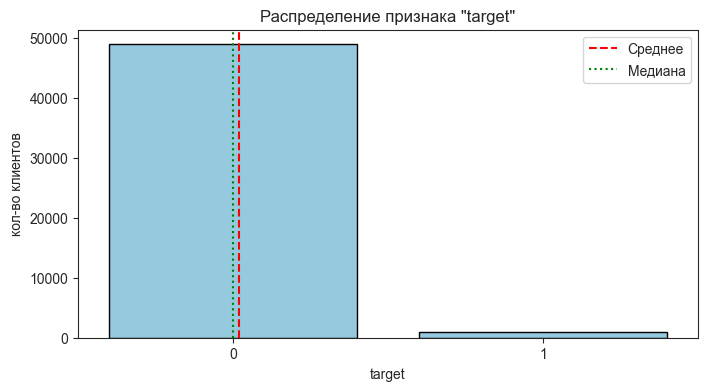

In [2710]:
custom_count_plot()

Наблюдаем сильный дисбаланс классов.<br/>

Дисбаланс требует специальных методов обработки, но не делает задачу нерешаемой.<br/>
Направляем фокус на ROC-AUC, правильную стратегию семплирования и на выбор алгоритмов для обучения модели, устойчивых к дисбалансу.

**Построим графики распределения признаков 'price' и 'quantity' датафрейма `purchases`.**

Статистика по столбцу "price" датафрейм purchases:


,count,mean,std,min,25%,50%,75%,max,median
price,"202,208.00","1,193.30","1,342.25",1.00,352.00,987.00,"1,699.00","85,499.00",987.00


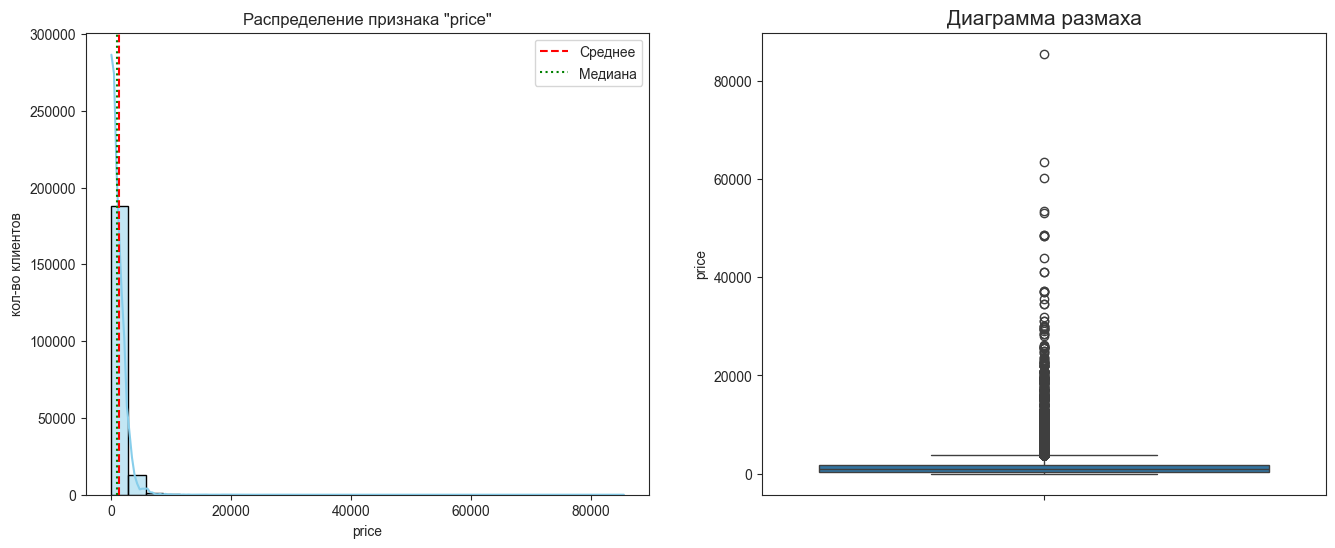

Статистика по столбцу "quantity" датафрейм purchases:


,count,mean,std,min,25%,50%,75%,max,median
quantity,"202,208.00",1.01,0.18,1.00,1.00,1.00,1.00,30.00,1.00


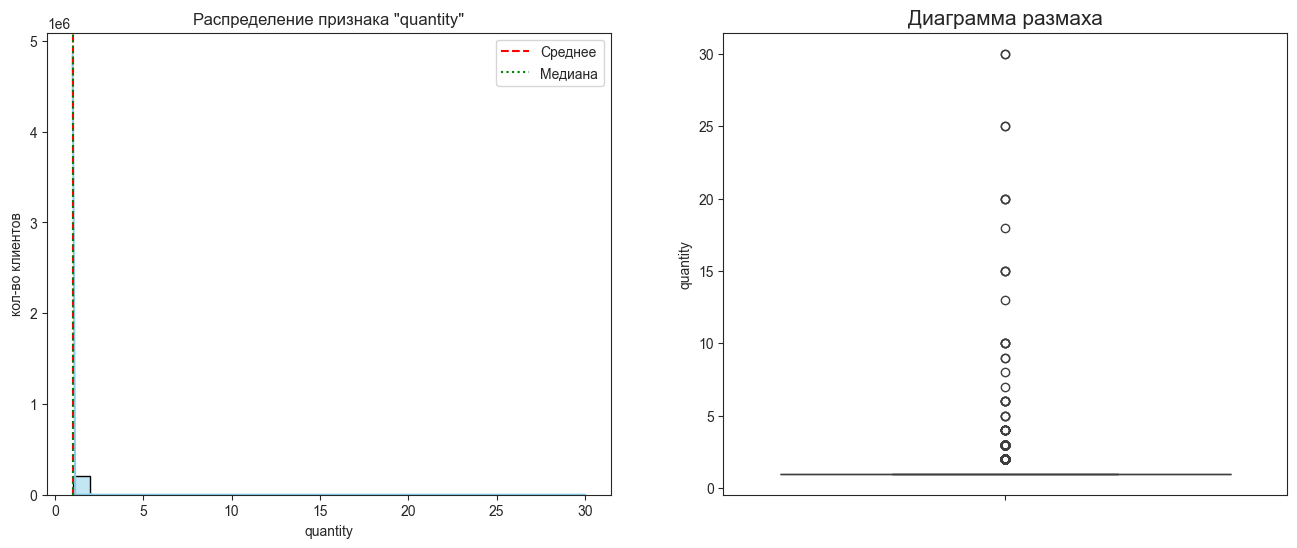

In [2711]:
custom_hist(add_columns=['quantity'])

**Анализ признака 'price' датафрейма `purchases`**

Ключевые наблюдения:
- Разброс значений: std (1,342) > mean (1,193)
- Экстремальные выбросы: max = 85,499 (в 50 раз больше 75% квантиля)
- Правостороннее распределение: mean > median
- Реальные цены: 75% товаров до 1,699, но есть очень дорогие товары

**Анализ признака 'quantity' датафрейма `purchases`**

Ключевые наблюдения:
- Почти константа: 99%+ покупок с quantity = 1
- Редкие исключения: максимум 30 штук (вероятно, оптовые покупки)
- Низкая информативность: малая вариативность

Обработаем поле 'price' датафрейма `purchases`.<br/>
Добавим дополнительные признаки:
- 'price_capped'
- 'price_group'

In [2712]:
# Обработка выбросов.
Q1 = purchases['price'].quantile(0.25)
Q3 = purchases['price'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 3 * IQR

# Каппирование выбросов.
purchases['price_capped'] = np.where(
    purchases['price'] > upper_bound,
    upper_bound,
    purchases['price']
)

# Биннинг для категоризации.
purchases['price_group'] = pd.cut(purchases['price'], 
                                 bins=[0, 100, 500, 1000, 5000, np.inf],
                                 labels=['cheap', 'low', 'medium', 'high', 'premium'])

# Стоимость покупки.
purchases['purchase_value'] = purchases['price'] * purchases['quantity']
purchases['purchase_value_capped'] = purchases['price_capped'] * purchases['quantity']

Обработаем поле 'quantity' датафрейма `purchases`.<br/>
Добавим дополнительные признаки:
- 'price_capped'
- 'price_group'
- 'purchase_value'
- 'purchase_value_capped'

In [2713]:
# 1. Бинаризация (так как почти все значения = 1)
purchases['is_bulk'] = (purchases['quantity'] > ONE).astype(int)

# 2. Группировка редких случаев
purchases['quantity_group'] = np.where(
    purchases['quantity'] == ONE, 'single',
    np.where(purchases['quantity'] <= SIX, 'small_bulk', 'large_bulk')
)

In [2714]:
custom_info(purchases, sample=True)

,non_null_count,dtype
client_id,202208,int64
quantity,202208,int64
price,202208,float64
category_ids,202208,object
date,202208,datetime64[ns]
message_id,202208,object
price_capped,202208,float64
price_group,202208,category
purchase_value,202208,float64
purchase_value_capped,202208,float64


Количество записей: 202208
Количество столбцов: 12


,155349,120122,168696,62309,97675,194255,145777,128341,84628,24396
client_id,1515915625738333017,1515915625490582556,1515915625487523488,1515915625541550494,1515915625501180971,1515915625472707637,1515915625877525972,1515915625505219349,1515915625589691573,1515915625491899573
quantity,1,1,1,1,1,1,1,1,1,1
price,"1,058.00",666.00,"2,199.00",11.00,"1,999.00",7.00,412.00,799.00,"2,249.00",49.00
category_ids,"['2', '18', '155', '439']","['2', '18', '212', '726']","['4', '31', '326', '505']","['5562', '5631', '5549', '667']","['2', '18', '61', '660']",[],"['4', '27', '142', '496']","['2', '18', '123', '451']","['4', '28', '62', '657']","['5562', '5536', '5537', '843']"
date,2023-07-07 00:00:00,2023-05-08 00:00:00,2023-09-10 00:00:00,2022-12-02 00:00:00,2023-03-30 00:00:00,2024-01-12 00:00:00,2023-06-24 00:00:00,2023-06-04 00:00:00,2023-02-08 00:00:00,2022-07-16 00:00:00
message_id,1515915625489607446-13456-64a7ddaf88fe7,1515915625490582556-12367-6454f165e34a6,1515915625487523488-13742-64eefc5c9b65e,1515915625541550494-8375-638a1d8cb14e0,1515915625501180971-11208-6423f1049654f,1515915625472707637-14456-659fb003a3f3a,1515915625877525972-13395-649574b11d647,1515915625505219349-13076-6479c366d787a,1515915625490715461-9945-63e34ea7a0483,1515915625491899573-5456-62d1029f09444
price_capped,"1,058.00",666.00,"2,199.00",11.00,"1,999.00",7.00,412.00,799.00,"2,249.00",49.00
price_group,high,medium,high,cheap,high,cheap,low,medium,high,cheap
purchase_value,"1,058.00",666.00,"2,199.00",11.00,"1,999.00",7.00,412.00,799.00,"2,249.00",49.00
purchase_value_capped,"1,058.00",666.00,"2,199.00",11.00,"1,999.00",7.00,412.00,799.00,"2,249.00",49.00


Статистика по столбцу "price" датафрейм purchases:


,count,mean,std,min,25%,50%,75%,max,median
price,"202,208.00","1,193.30","1,342.25",1.00,352.00,987.00,"1,699.00","85,499.00",987.00


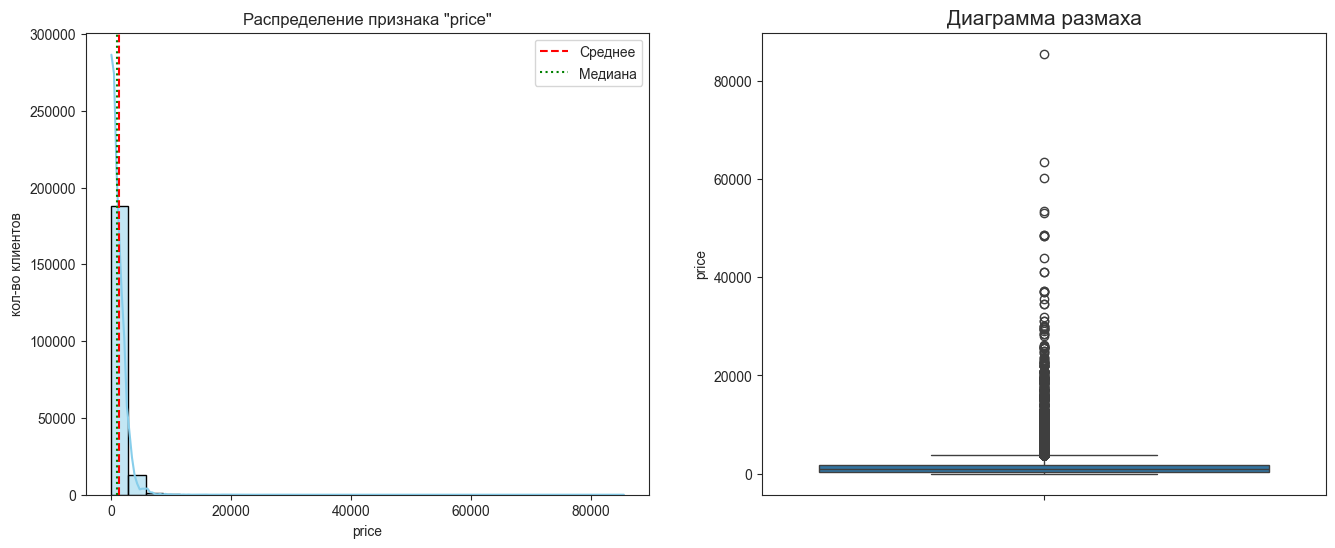

Статистика по столбцу "price_capped" датафрейм purchases:


,count,mean,std,min,25%,50%,75%,max,median
price_capped,"202,208.00","1,166.18","1,076.77",1.00,352.00,987.00,"1,699.00","5,740.00",987.00


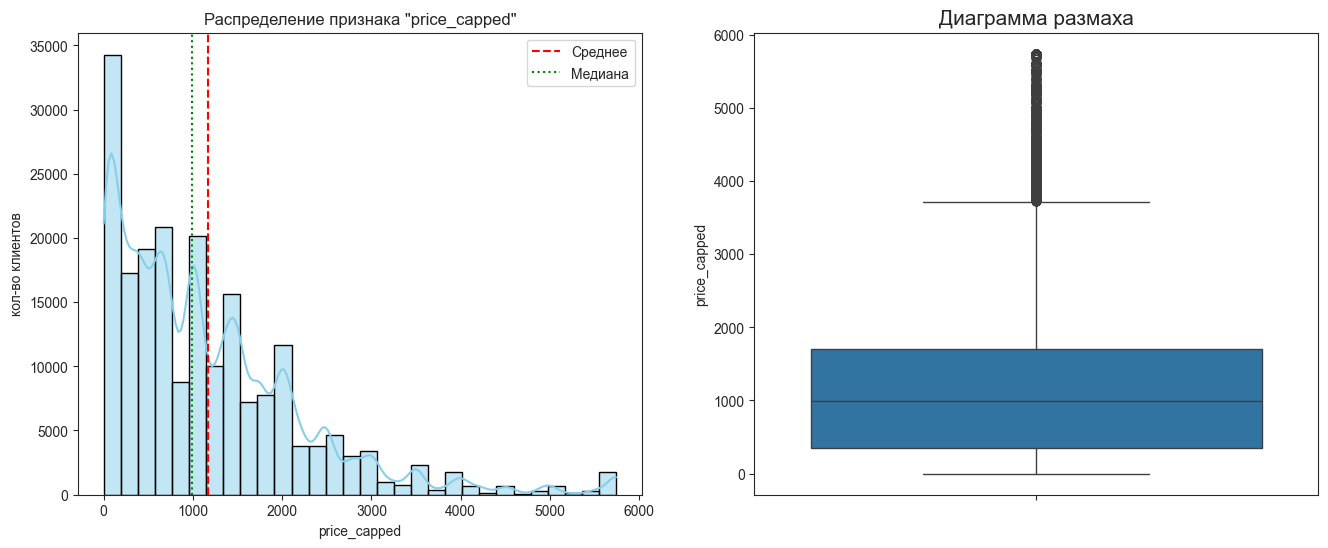

Статистика по столбцу "purchase_value" датафрейм purchases:


,count,mean,std,min,25%,50%,75%,max,median
purchase_value,"202,208.00","1,199.48","1,355.02",1.00,355.00,997.00,"1,699.00","85,499.00",997.00


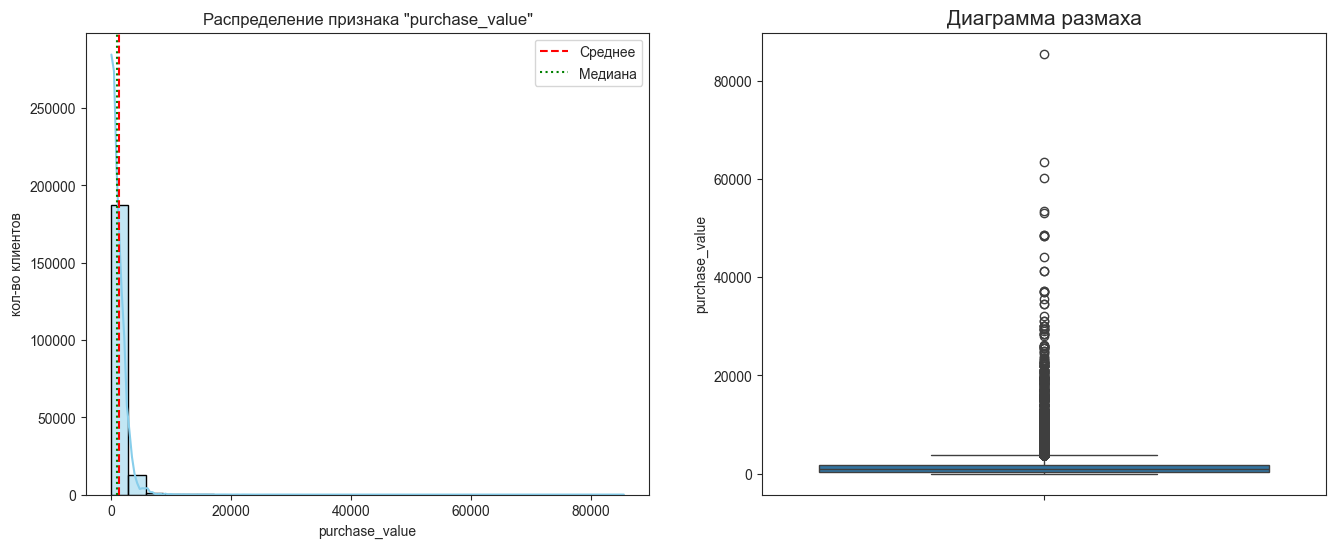

Статистика по столбцу "purchase_value_capped" датафрейм purchases:


,count,mean,std,min,25%,50%,75%,max,median
purchase_value_capped,"202,208.00","1,172.31","1,091.47",1.00,355.00,997.00,"1,699.00","17,220.00",997.00


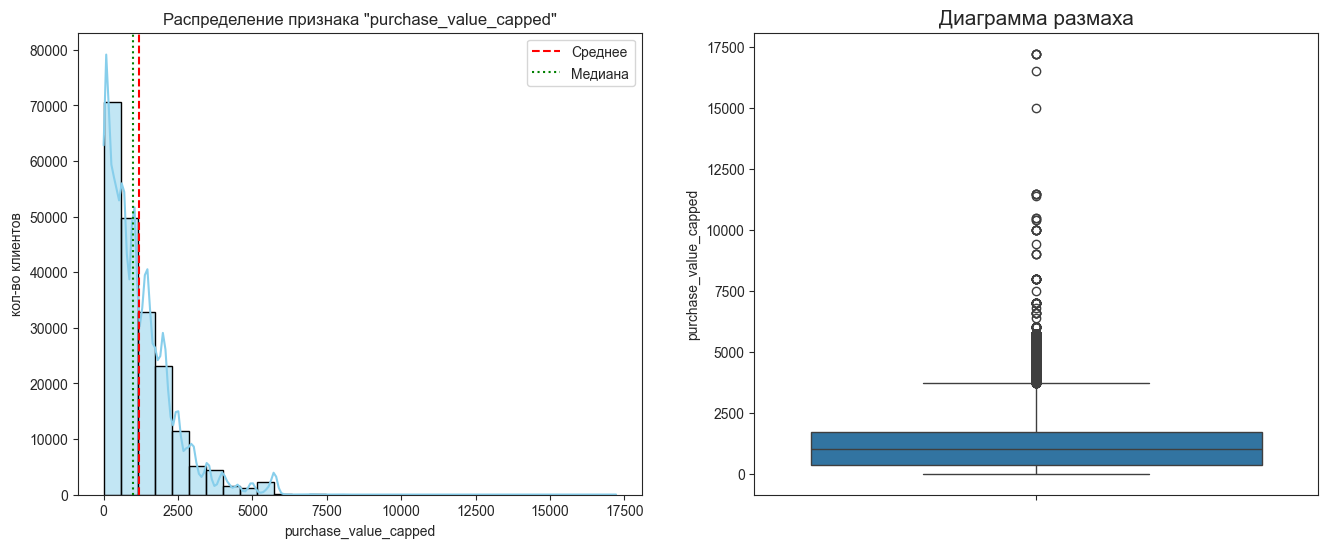

In [2715]:
custom_hist()

**Построим графики распределения признаков 'category_ids' и 'price' датафрейма `purchases`.**

In [2716]:
# Метод для дополнительной статистики категорий товаров.
def add_stats_for_category(data, price_col='price'):

    print('Статистика категорий:\n')
    
    # Общая статистика.
    total_products = len(data)
    products_with_categories = data[data['category_depth'] > 0].shape[0]
    
    print(f'Всего товаров: {total_products:,}')
    print(f'Товаров с категориями: {products_with_categories:,} ({products_with_categories/total_products:.1%})')
    print(f"Максимальная глубина категории: {data['category_depth'].max()}")
    print(f"Средняя глубина категории: {data['category_depth'].mean():.2f}")
    
    # Уникальные категории.
    all_categories = []
    for cats in data['parsed_categories']:
        all_categories.extend(cats)
    
    print(f'Уникальных категорий всех уровней: {len(set(all_categories)):,}')
    print(f"Уникальных основных категорий: {data['main_category'].nunique():,}")
    print(f"Уникальных первых уровней: {data['first_level'].nunique():,}")
    
    # Анализ пустых категорий.
    empty_categories = data[data['category_depth'] == 0].shape[0]
    if empty_categories > 0:
        print(f'\n{empty_categories:,} товаров без категорий.')
        print('Примеры товаров без категорий:')
        no_cat_samples = data[data['category_depth'] == 0].head(SIX)
        for _, row in no_cat_samples.iterrows():
            print(f'  - Price: {row[price_col]}, ID: {row.name}')
    
    # Топ-5 самых дорогих и дешевых категорий.
    print(f'\nСамые дорогие категории:')
    expensive_cats = data.groupby('main_category')[price_col].mean().sort_values(ascending=False).head(SIX)
    for cat, price in expensive_cats.items():
        print(f'  - {cat}: {price:,.2f}')
    
    print(f'\nСамые популярные категории:')
    popular_cats = data['main_category'].value_counts().head(SIX)
    for cat, count in popular_cats.items():
        print(f'  - {cat}: {count:,} товаров')

In [2717]:
# Метод анализа категорий товаров.
def analyze_categories(data, category_col='category_ids', price_col='price', figsize=(15, 12)):

    fig = plt.figure(figsize=figsize)
    
    # Распределение глубины категорий.
    plt.subplot(3, 2, 1)
    depth_counts = data['category_depth'].value_counts().sort_index()
    plt.bar(depth_counts.index, depth_counts.values)
    plt.xlabel('Глубина категории (уровни вложенности)')
    plt.ylabel('Количество товаров')
    plt.title('Распределение по глубине категорий')
    for i, v in enumerate(depth_counts.values):
        plt.text(depth_counts.index[i], v + 0.01, str(v), ha='center')
    
    # Топ-10 основных категорий.
    plt.subplot(3, 2, 2)
    top_categories = data['main_category'].value_counts().head(TEN)
    plt.barh(range(len(top_categories)), top_categories.values)
    plt.yticks(range(len(top_categories)), top_categories.index)
    plt.xlabel('Количество товаров')
    plt.title('Топ-10 основных категорий (последний уровень)')
    
    # Топ-10 первых уровней категорий.
    plt.subplot(3, 2, 3)
    top_first_level = data['first_level'].value_counts().head(TEN)
    plt.barh(range(len(top_first_level)), top_first_level.values)
    plt.yticks(range(len(top_first_level)), top_first_level.index)
    plt.xlabel('Количество товаров')
    plt.title('Топ-10 первых уровней категорий')
    
    # Средняя цена по основным категориям (топ-10).
    plt.subplot(3, 2, 4)
    price_by_category = data.groupby('main_category')[price_col].mean().sort_values(ascending=False).head(TEN)
    plt.barh(range(len(price_by_category)), price_by_category.values)
    plt.yticks(range(len(price_by_category)), price_by_category.index)
    plt.xlabel('Средняя цена')
    plt.title('Топ-10 самых дорогих категорий')
    
    # Анализ самых частых путей категорий.
    plt.subplot(3, 2, 5)
    # Берем топ-10 полных путей
    full_paths = data[category_col].value_counts().head(TEN)
    paths_for_plot = []
    values_for_plot = []
    
    for path, count in full_paths.items():
        try:
            parsed = ast.literal_eval(path) if isinstance(path, str) else path
            display_path = ' → '.join(parsed) if parsed else 'empty'
            paths_for_plot.append(display_path)
            values_for_plot.append(count)
        except:
            continue
    
    plt.barh(range(len(paths_for_plot)), values_for_plot)
    plt.yticks(range(len(paths_for_plot)), paths_for_plot, fontsize=8)
    plt.xlabel('Количество товаров')
    plt.title('Топ-10 полных путей категорий')
    
    # Распределение цен по уровням вложенности.
    plt.subplot(3, 2, 6)
    price_by_depth = data.groupby('category_depth')[price_col].agg(['mean', 'median', 'std'])
    x_pos = np.arange(len(price_by_depth))
    
    plt.bar(x_pos, price_by_depth['mean'], yerr=price_by_depth['std'], 
            capsize=5, alpha=0.7, label='Средняя цена')
    plt.plot(x_pos, price_by_depth['median'], 'ro-', label='Медианная цена')
    
    plt.xlabel('Глубина категории')
    plt.ylabel('Цена')
    plt.title('Цены по глубине категорий')
    plt.legend()
    plt.xticks(x_pos, price_by_depth.index)
    
    plt.tight_layout()
    plt.show()

    # Дополнительная статистика.
    add_stats_for_category(data, price_col='price')

    # return data

Построим графики и выведем статистику по категориям товаров.<br/>
Добавим полезные признаки в датафрейм `purchases`:
- 'parsed_categories' - преобразованные категории в список
- 'category_depth' - уровень вложенности категорий
- 'main_category' - базовая категория, последний уровень вложенности
- 'first_level' - категория на первом уровне вложенности

In [2718]:
# Предобработка категорий и добавление полезных признаков.
def parse_categories(cat_str):
    try:
        if pd.isna(cat_str) or cat_str == '[]' or cat_str == '[None]':
            return []
        if isinstance(cat_str, str):
            return ast.literal_eval(cat_str)
        return cat_str
    except:
        return []

purchases['parsed_categories'] = purchases['category_ids'].apply(parse_categories)
purchases['category_depth'] = purchases['parsed_categories'].apply(len)
purchases['main_category'] = purchases['parsed_categories'].apply(
    lambda x: x[-ONE] if x and len(x) > 0 else 'no_category')
purchases['first_level'] = purchases['parsed_categories'].apply(
    lambda x: x[ZERO] if x and len(x) > 0 else 'no_category')

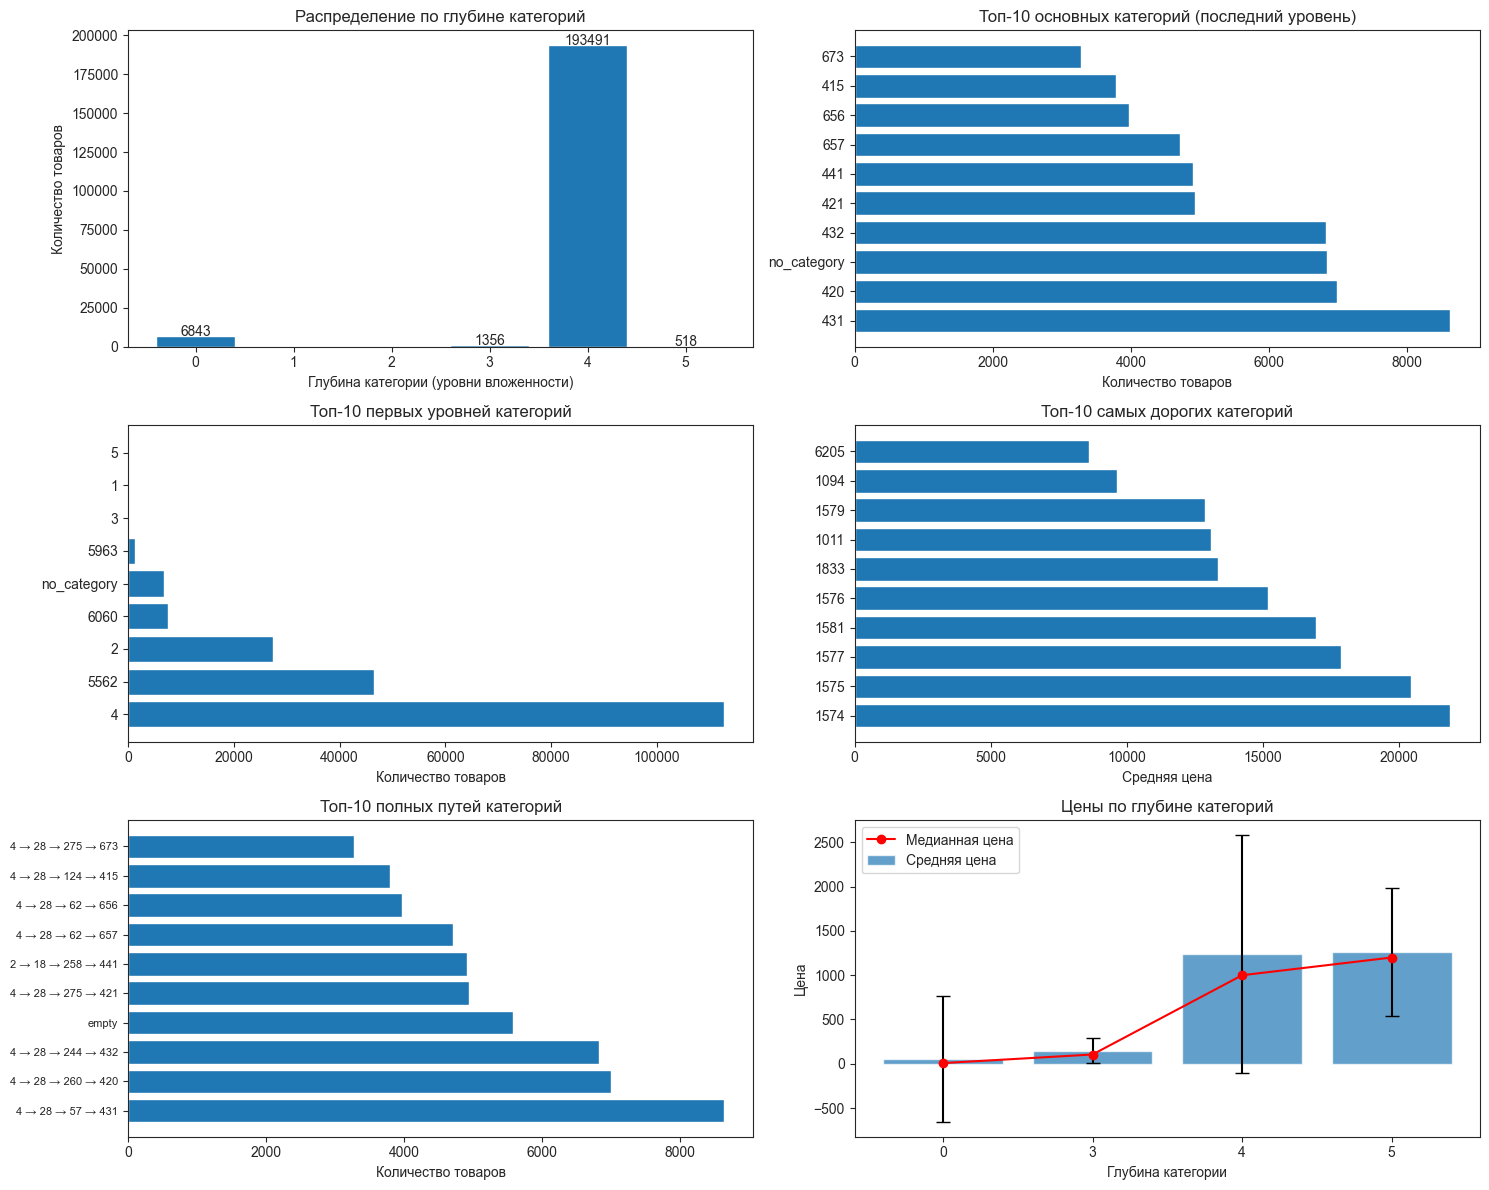

Статистика категорий:

Всего товаров: 202,208
Товаров с категориями: 195,365 (96.6%)
Максимальная глубина категории: 5
Средняя глубина категории: 3.86
Уникальных категорий всех уровней: 1,151
Уникальных основных категорий: 843
Уникальных первых уровней: 9

6,843 товаров без категорий.
Примеры товаров без категорий:
  - Price: 2499.0, ID: 14848
  - Price: 1.0, ID: 22153
  - Price: 1.0, ID: 22154
  - Price: 8.0, ID: 32281
  - Price: 8.0, ID: 32282
  - Price: 1.0, ID: 32283

Самые дорогие категории:
  - 1574: 21,885.08
  - 1575: 20,432.14
  - 1577: 17,864.38
  - 1581: 16,951.50
  - 1576: 15,190.76
  - 1833: 13,346.67

Самые популярные категории:
  - 431: 8,626 товаров
  - 420: 6,989 товаров
  - no_category: 6,843 товаров
  - 432: 6,821 товаров
  - 421: 4,936 товаров
  - 441: 4,905 товаров


In [2719]:
# Вывод графиков и статистики по категориям товаров.
analyze_categories(purchases, 'category_ids', 'price')

По результату анализа категорий, наблюдаем:
- Категории имеют разную глубину вложенности (2-4 уровня)
- Есть товары без категорий

В процессе анализа создали несколько полезных признаков.<br/>
Наиболее значимый 'main_category' - категория, последнего уровня вложенности.<br/>
Использование данного признака дает несколько преимуществ:
- Все категории на одном уровне детализации - некоторая унификация
- Последний уровень наиболее специфичен - информативность данных
- Не зависит от изменений в структуре категорий - предоставляет устойчивость данных
- Легче для обработки в моделях - простота интерпретации

In [2720]:
custom_info(purchases, sample=True)

,non_null_count,dtype
client_id,202208,int64
quantity,202208,int64
price,202208,float64
category_ids,202208,object
date,202208,datetime64[ns]
message_id,202208,object
price_capped,202208,float64
price_group,202208,category
purchase_value,202208,float64
purchase_value_capped,202208,float64


Количество записей: 202208
Количество столбцов: 16


,84169,136169,171105,24330,101304,18542,183167,54270,50823,23715
client_id,1515915625501948800,1515915625503050426,1515915625488094521,1515915625486647406,1515915625491137818,1515915625561030234,1515915625565806782,1515915625581479543,1515915625590386570,1515915625553187728
quantity,1,1,1,1,1,1,1,1,1,1
price,"3,499.00","1,097.00",319.00,599.00,999.00,399.00,"4,637.00","1,554.00",70.00,399.00
category_ids,"['4', '28', '275', '421']","['5562', '5630', '5607', '1326']","['5562', '5630', '5607', '555']","['4', '28', '57', '431']","['4', '28', '260', '420']","['4', '28', '244', '432']","['4', '28', '260', '1194']","['4', '28', '62', '657']","['4', '28', '44', '491']","['5562', '5634', '5626', '572']"
date,2023-01-28 00:00:00,2023-06-11 00:00:00,2023-09-27 00:00:00,2022-07-16 00:00:00,2023-04-12 00:00:00,2022-06-30 00:00:00,2023-12-20 00:00:00,2022-11-14 00:00:00,2022-11-12 00:00:00,2022-07-14 00:00:00
message_id,1515915625487560441-9630-63d380efec858,1515915625875268681-13319-6483f59685565,1515915625488094521-13825-6513c55b75819,1515915625486647406-5335-62c7d2db274c9,1515915625491137818-11763-64365d7c5d100,1515915625561030234-5204-62bc5af15ffe8,1515915625565806782-14337-658134f2aeb1b,1515915625589706049-7820-6370c03f1e3b0,1515915625854250139-7818-636f6ece6dd2c,1515915625553187728-5407-62cfb80bb2fd0
price_capped,"3,499.00","1,097.00",319.00,599.00,999.00,399.00,"4,637.00","1,554.00",70.00,399.00
price_group,high,high,low,medium,medium,low,high,high,cheap,low
purchase_value,"3,499.00","1,097.00",319.00,599.00,999.00,399.00,"4,637.00","1,554.00",70.00,399.00
purchase_value_capped,"3,499.00","1,097.00",319.00,599.00,999.00,399.00,"4,637.00","1,554.00",70.00,399.00


**Построим графики распределения признаков 'event' и 'channel' датафрейма `messages`.**

In [2721]:
def custom_count(data=messages,
                 figsize=(10, 5),
                 x='channel',
                 hue='event'):

    plt.figure(figsize=figsize)
    sns.countplot(data=data, x=x, palette='viridis', hue=hue)
    plt.title(f'Распределение по {x.lower()} в выбранном сегменте')
    # Автоповорот в зависимости от количества категорий.
    if len(data[x].unique()) > 7:
        plt.xticks(rotation=45)
    else:
        plt.xticks(rotation=0)
    
    plt.tight_layout()
    plt.xlabel(x)
    plt.ylabel('Количество событий')
    plt.show()

In [2722]:
# Дополнительная функция для вывода сводной статистики
def print_summary_stats(data, x, hue):
    print(f'Сводная статистика по {x} и {hue}:\n')
    
    # Создаем сводную таблицу.
    pivot_table = pd.crosstab(data[x], data[hue], margins=True, margins_name='Всего')
    
    # Добавляем проценты по строкам.
    pivot_percent = pd.crosstab(data[x], data[hue], normalize='index') * 100
    pivot_percent = pivot_percent.round(1)
    
    print('Абсолютные значения:')
    print(pivot_table)
    print('\nПроцентное распределение по строкам:')
    print(pivot_percent)
    
    # Общая статистика.
    print(f'\nОбщее количество записей: {len(data):,}')
    print(f'Уникальных значений {x}: {data[x].nunique()}')
    print(f'Уникальных значений {hue}: {data[hue].nunique()}')

In [2723]:
# Метод вывода статистики и построения графиков по анализу каналов и событий.
def enhanced_custom_count(data=messages,
                         x='channel',
                         hue='event'):

    # Выводим статистику.
    print_summary_stats(data, x, hue)
    print('\n')
    
    # Cтроим графики.
    custom_count(x=x, hue=hue)
    custom_count(x=hue, hue=x)

Анализ каналов и событий:
Сводная статистика по channel и event:

Абсолютные значения:
event         click  close  complain  hard_bounce  hbq_spam     open  \
channel                                                                
email        351949      0       527          359       823   873138   
mobile_push  131377      1         0        19404         0  2179343   
Всего        483326      1       527        19763       823  3052481   

event        purchase     send  soft_bounce  subscribe  unsubscribe     Всего  
channel                                                                        
email           44215  3937221         9566         85         2833   5220716  
mobile_push     18378  5120953         1016          0            0   7470472  
Всего           62593  9058174        10582         85         2833  12691188  

Процентное распределение по строкам:
event        click  close  complain  hard_bounce  hbq_spam  open  purchase  \
channel                             

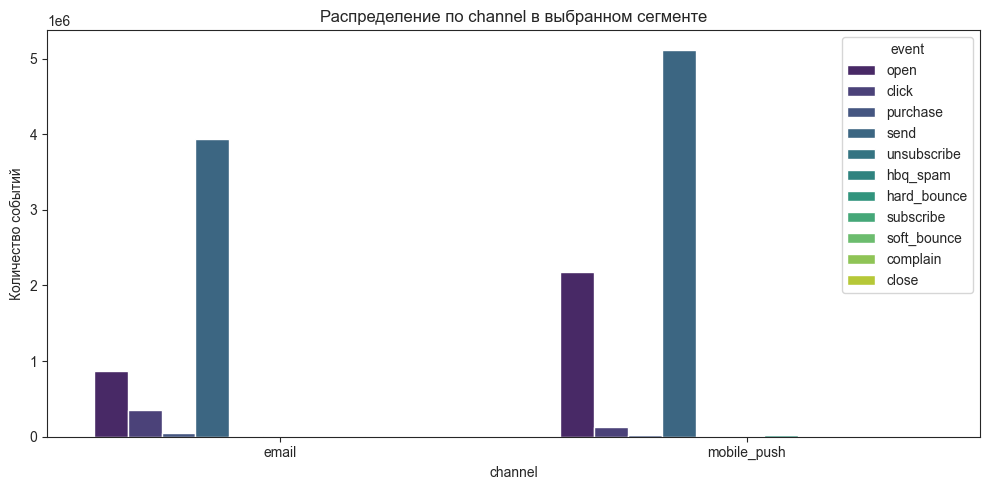

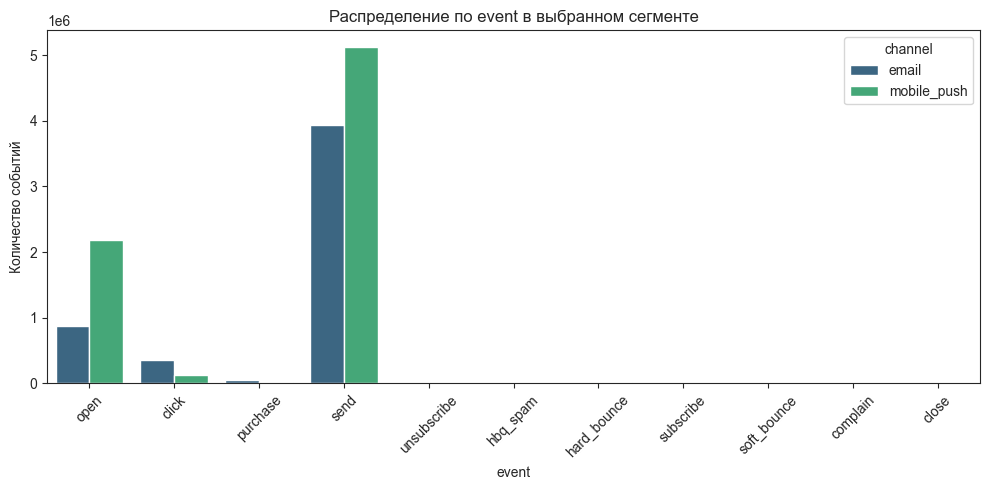

In [2724]:
# Анализ каналов и событий.
print('Анализ каналов и событий:')
enhanced_custom_count()

Наблюдаем наибольшую активность по событиям `open` и `send`.

## Разработка полезных признаков, агрегация данных и объединение датафреймов.

In [2725]:
# Метод по финальной агрегации датафреймов purchases и messages с соединением target.
# С учетом 90-дневного горизонта прогнозирования.
def create_final_aggregation_with_messages(purchases, messages, target):
    
    # Определяем временные границы.
    last_date = max(purchases['date'].max(), messages['date'].max())
    cutoff_date = last_date - pd.Timedelta(days=90)
    
    # Разделяем данные: до cutoff_date для фичей.
    train_purchases = purchases[purchases['date'] <= cutoff_date].copy()
    train_messages = messages[messages['date'] <= cutoff_date].copy()
    
    # 1. Агрегация purchases.
    
    # Базовые монетарные признаки.
    monetary_agg = train_purchases.groupby('client_id').agg({
        'purchase_value_capped': ['sum', 'mean', 'max', 'std'],
        'price_capped': ['mean', 'median', 'std'],
        'quantity': ['sum', 'mean']
    }).round(2)
    
    monetary_agg.columns = [
        'total_spent', 'avg_order_value', 'max_order_value', 'spending_std',
        'avg_price', 'median_price', 'price_std',
        'total_items', 'avg_items_per_order'
    ]
    
    # Частотные и временные признаки.
    frequency_agg = train_purchases.groupby('client_id').agg({
        'date': ['count', 'min', 'max', 'nunique']
    })
    
    frequency_agg.columns = ['purchase_count', 'first_purchase', 'last_purchase', 'unique_purchase_days']
    frequency_agg['days_since_last_purchase'] = (cutoff_date - frequency_agg['last_purchase']).dt.days
    frequency_agg['customer_lifetime_days'] = (frequency_agg['last_purchase'] - frequency_agg['first_purchase']).dt.days
    frequency_agg['purchase_frequency'] = frequency_agg['purchase_count'] / (frequency_agg['customer_lifetime_days'] + 1)
    
    # Категорийные признаки.
    top_categories = train_purchases['main_category'].value_counts().nlargest(10).index
    category_agg = train_purchases.groupby('client_id').agg({
        'main_category': lambda x: x.mode()[0] if not x.mode().empty else 'no_category',
        'first_level': lambda x: x.mode()[0] if not x.mode().empty else 'no_category',
        'category_depth': 'mean'
    })
    
    category_agg.columns = ['fav_category', 'fav_first_level', 'avg_category_depth']
    
    # Bulk покупки.
    bulk_agg = train_purchases.groupby('client_id').agg({
        'is_bulk': 'sum',
        'quantity_group': lambda x: (x == 'small_bulk').sum()
    })
    
    bulk_agg.columns = ['bulk_purchases_count', 'small_bulk_count']
    bulk_agg['bulk_ratio'] = bulk_agg['bulk_purchases_count'] / frequency_agg['purchase_count']
    
    # Временные окна активности purchases.
    purchase_window_aggs = []
    for window in [30, 60, 90]:
        window_mask = (train_purchases['date'] > (cutoff_date - pd.Timedelta(days=window))) & (train_purchases['date'] <= cutoff_date)
        window_data = train_purchases[window_mask]
        
        window_stats = window_data.groupby('client_id').agg({
            'purchase_value_capped': ['sum', 'count'],
            'price_capped': 'mean'
        }).round(2)
        
        window_stats.columns = [f'purchases_last_{window}d_spent', f'purchases_last_{window}d_orders', f'purchases_last_{window}d_avg_price']
        purchase_window_aggs.append(window_stats)
    
    # 2. Агрегация messages.
    
    # Базовые признаки рассылок.
    messages_agg = train_messages.groupby('client_id').agg({
        'event': 'count',
        'bulk_campaign_id': 'nunique',
        'channel': lambda x: x.mode()[0] if not x.mode().empty else 'no_channel',
        'date': ['min', 'max']
    })
    
    messages_agg.columns = [
        'total_messages', 'unique_campaigns', 'preferred_channel',
        'first_message_date', 'last_message_date'
    ]
    
    # Признаки по типам событий.
    event_counts = train_messages.pivot_table(
        index='client_id', columns='event', values='message_id', 
        aggfunc='count', fill_value=0
    )
    event_counts.columns = [f'messages_{event}_count' for event in event_counts.columns]
    
    # Признаки по каналам.
    channel_counts = train_messages.pivot_table(
        index='client_id', columns='channel', values='message_id', 
        aggfunc='count', fill_value=0
    )
    channel_counts.columns = [f'messages_{channel}_count' for channel in channel_counts.columns]
    
    # Конверсионные метрики.
    if 'purchase' in event_counts.columns:
        event_counts['conversion_rate'] = event_counts['messages_purchase_count'] / (event_counts['messages_send_count'] + 1e-6)
        event_counts['engagement_rate'] = (event_counts['messages_open_count'] + event_counts['messages_click_count']) / (event_counts['messages_send_count'] + 1e-6)
    
    # Временные окна активности messages.
    messages_window_aggs = []
    for window in [30, 60, 90]:
        window_mask = (train_messages['date'] > (cutoff_date - pd.Timedelta(days=window))) & (train_messages['date'] <= cutoff_date)
        window_data = train_messages[window_mask]
        
        window_stats = window_data.groupby('client_id').agg({
            'event': 'count',
            'bulk_campaign_id': 'nunique'
        })
        
        window_stats.columns = [f'messages_last_{window}d_count', f'messages_last_{window}d_campaigns']
        messages_window_aggs.append(window_stats)
        
        # События в окне.
        window_events = window_data.pivot_table(
            index='client_id', columns='event', values='message_id', 
            aggfunc='count', fill_value=0
        )
        window_events.columns = [f'messages_last_{window}d_{event}_count' for event in window_events.columns]
        messages_window_aggs.append(window_events)
    
    # 3. Объединение в общий датафрейм.
    
    # Объединяем purchases.
    all_aggregates = monetary_agg.merge(
        frequency_agg, on='client_id', how='left'
    ).merge(
        category_agg, on='client_id', how='left'
    ).merge(
        bulk_agg, on='client_id', how='left'
    )
    
    for window_agg in purchase_window_aggs:
        all_aggregates = all_aggregates.merge(window_agg, on='client_id', how='left')
    
    # Объединяем messages.
    all_aggregates = all_aggregates.merge(
        messages_agg, on='client_id', how='left'
    ).merge(
        event_counts, on='client_id', how='left'
    ).merge(
        channel_counts, on='client_id', how='left'
    )
    
    for window_agg in messages_window_aggs:
        all_aggregates = all_aggregates.merge(window_agg, on='client_id', how='left')
    
    # 4. Создание полезных признаков.
    
    # Тренды purchases.
    all_aggregates['purchases_spending_trend_30_60'] = (
        all_aggregates['purchases_last_30d_spent'] / 
        (all_aggregates['purchases_last_60d_spent'] - all_aggregates['purchases_last_30d_spent'] + 1e-6)
    )
    
    all_aggregates['purchases_frequency_trend_30_60'] = (
        all_aggregates['purchases_last_30d_orders'] / 
        (all_aggregates['purchases_last_60d_orders'] - all_aggregates['purchases_last_30d_orders'] + 1e-6)
    )
    
    # Тренды messages.
    all_aggregates['messages_frequency_trend_30_60'] = (
        all_aggregates['messages_last_30d_count'] / 
        (all_aggregates['messages_last_60d_count'] - all_aggregates['messages_last_30d_count'] + 1e-6)
    )
    
    # 5. Флаги активности.
    
    for window in [30, 60, 90]:
        all_aggregates[f'purchases_active_last_{window}d'] = (all_aggregates[f'purchases_last_{window}d_orders'] > 0).astype(int)
        all_aggregates[f'messages_active_last_{window}d'] = (all_aggregates[f'messages_last_{window}d_count'] > 0).astype(int)
    
    # 6. Соединение с target.
    
    final_df = target.merge(all_aggregates, on='client_id', how='left')
    
    # Заполняем event counts.
    event_cols = [col for col in final_df.columns if col.startswith('messages_') and col.endswith('_count')]
    
    # 7. Финальные преобразования.
    
    # Категориальные признаки.
    categorical_cols = ['fav_category', 'fav_first_level', 'preferred_channel']
    for col in categorical_cols:
        final_df[col] = final_df[col].fillna('unknown')
        final_df[col] = final_df[col].astype('category').cat.codes
    
    # Дополнительные вычисляемые признаки.
    final_df['value_per_day'] = final_df['total_spent'] / (final_df['customer_lifetime_days'] + 1)
    final_df['messages_per_day'] = final_df['total_messages'] / ((cutoff_date - final_df['first_message_date']).dt.days + 1)
    
    # Удаление временных столбцов.
    date_cols = [col for col in final_df.columns if final_df[col].dtype == 'datetime64[ns]']
    final_df.drop(columns=date_cols, inplace=True, errors='ignore')
    
    print(f"Создан финальный датафрейм с {len(final_df)} клиентами и {len(final_df.columns)} признаками")
    print(f"Распределение целевой переменной: {final_df['target'].mean():.2%} положительных примеров")

    # Заполняем пропуски.
    final_df.fillna(0, inplace=True)
    
    return final_df

# Выполнение агрегации.
final_dataset = create_final_aggregation_with_messages(purchases, messages, target)

Создан финальный датафрейм с 49849 клиентами и 88 признаками
Распределение целевой переменной: 1.93% положительных примеров


In [2726]:
custom_info(final_dataset, sample=True)

,non_null_count,dtype
client_id,49849,int64
target,49849,int64
total_spent,49849,float64
avg_order_value,49849,float64
max_order_value,49849,float64
...,...,...
messages_active_last_60d,49849,float64
purchases_active_last_90d,49849,float64
messages_active_last_90d,49849,float64
value_per_day,49849,float64


Количество записей: 49849
Количество столбцов: 88


,39408,12232,23650,25167,34588,39342,186,30025,10650,43769
client_id,"1,515,915,625,688,283,648.00","1,515,915,625,489,893,888.00","1,515,915,625,549,125,376.00","1,515,915,625,557,292,032.00","1,515,915,625,590,524,160.00","1,515,915,625,684,570,624.00","1,515,915,625,468,075,008.00","1,515,915,625,570,378,240.00","1,515,915,625,489,313,792.00","1,515,915,625,817,025,280.00"
target,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
total_spent,598.00,"1,499.00","2,656.00","2,598.00","1,737.00",399.00,"5,958.00","9,797.00","9,192.00","2,399.00"
avg_order_value,299.00,"1,499.00",442.67,"1,299.00","1,737.00",399.00,744.75,"3,265.67",766.00,"2,399.00"
max_order_value,299.00,"1,499.00",700.00,"1,299.00","1,737.00",399.00,"2,199.00","3,999.00",938.00,"2,399.00"
...,...,...,...,...,...,...,...,...,...,...
messages_active_last_60d,1.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,0.00
purchases_active_last_90d,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
messages_active_last_90d,1.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,0.00
value_per_day,598.00,"1,499.00","2,656.00","2,598.00","1,737.00",399.00,18.74,"9,797.00","9,192.00","2,399.00"


In [2727]:
count_none_values_table(final_dataset, 'final_dataset')

В датафрейме final_dataset нет пропущенных значений.


In [2728]:
# Составим список с числовыми непрерывными категориями.
cols_num = (final_dataset
        .drop(columns=ID)
        .select_dtypes(exclude=['object', 'int64'])
        .columns.to_list())

In [2729]:
# Матрица корреляций.
result = final_dataset.drop(columns=ID)
phik_overview = phik_matrix(result, interval_cols=cols_num)

In [2730]:
display(phik_overview['target']
        .to_frame()
        .sort_values('target', ascending=False))

,target
target,1.00
customer_lifetime_days,0.11
days_since_last_purchase,0.10
messages_click_count,0.09
unique_purchase_days,0.08
...,...
purchase_frequency,0.00
messages_last_60d_hard_bounce_count,0.00
messages_last_30d_hard_bounce_count,0.00
avg_items_per_order,0.00


In [2731]:
# Метод обработки мультиколлинеарности и выбора оптимального набора признаков.
def handle_multicollinearity(final_df, target_col='target', correlation_threshold=0.9):
    
    # Анализ корреляционной матрицы.
    features_df = final_df.drop(columns=['client_id', target_col], errors='ignore')
    corr_matrix = features_df.corr()
    
    print('Анализ мультиколлинеарности:')
    print('=' * 50)
    
    # Выявление высококоррелированных признаков.
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
                high_corr_pairs.append((
                    corr_matrix.columns[i], 
                    corr_matrix.columns[j],
                    round(corr_matrix.iloc[i, j], 3)
                ))
    
    if high_corr_pairs:
        print(f'Высококоррелированные пары признаков (>{correlation_threshold}):')
        for pair in high_corr_pairs:
            print(f"  {pair[0]} ↔ {pair[1]}: {pair[2]}")
    else:
        print('Высококоррелированных пар не обнаружено')
    
    # Выбор признаков для исключения.
    features_to_drop = set()
    
    # Правила для исключения признаков (приоритет сохранения более значимых)
    exclusion_rules = {
        # Сохраняем total_spent вместо purchase_count (более информативно)
        'purchase_count': ['total_spent', 'last_30d_orders'],
        # Сохраняем engagement_rate вместо абсолютных значений
        'engagement_events': ['engagement_rate', 'total_messages'],
        # Сохраняем частотные метрики вместо абсолютных
        'last_30d_messages': ['total_messages', 'engagement_rate'],
        # Сохраняем was_active флаги вместо количественных
        'last_30d_orders': ['was_active_30d_purchases', 'total_spent']
    }
    
    for pair in high_corr_pairs:
        feat1, feat2, corr_value = pair
        
        # Применяем правила приоритетности
        if feat1 in exclusion_rules and feat2 in exclusion_rules[feat1]:
            features_to_drop.add(feat2)
            print(f'Исключаем {feat2} (сохраняем {feat1})')
        elif feat2 in exclusion_rules and feat1 in exclusion_rules[feat2]:
            features_to_drop.add(feat1)
            print(f'Исключаем {feat1} (сохраняем {feat2})')
        else:
            # По умолчанию исключаем тот, что слабее коррелирует с целевой
            corr_with_target1 = abs(features_df[feat1].corr(final_df[target_col]))
            corr_with_target2 = abs(features_df[feat2].corr(final_df[target_col]))
            
            if corr_with_target1 > corr_with_target2:
                features_to_drop.add(feat2)
                print(f'Исключаем {feat2} (корр с target: {corr_with_target2:.3f} < {corr_with_target1:.3f})')
            else:
                features_to_drop.add(feat1)
                print(f'Исключаем {feat1} (корр с target: {corr_with_target1:.3f} < {corr_with_target2:.3f})')
    
    # Создание оптимизированного набора признаков.
    optimized_features = [col for col in final_df.columns if col not in features_to_drop]
    optimized_df = final_df[optimized_features]
    
    print(f'\nИсключено признаков: {len(features_to_drop)}')
    print(f'Осталось признаков: {len(optimized_df.columns)}')
    
    # Создание новых признаков вместо исключенных.
    if 'purchase_count' in features_to_drop and 'total_spent' in optimized_df.columns:
        optimized_df['avg_order_value'] = optimized_df['total_spent'] / (optimized_df.get('purchase_count', 1) + 1e-6)
    
    if 'engagement_events' in features_to_drop and 'total_messages' in optimized_df.columns:
        optimized_df['engagement_rate'] = optimized_df.get('engagement_events', 0) / (optimized_df['total_messages'] + 1e-6)
    
    # VIF анализ для проверки мультиколлинеарности.
    # Вычисляем VIF для оставшихся признаков
    X = add_constant(optimized_df.drop(columns=['client_id', target_col], errors='ignore'))
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    print('\nVIF анализ после оптимизации:')
    print(vif_data.sort_values('VIF', ascending=False).head(10))
    
    # Исключение признаков с высоким VIF (>10).
    high_vif_features = vif_data[vif_data['VIF'] > 10]['feature'].tolist()
    high_vif_features = [f for f in high_vif_features if f != 'const']
    
    if high_vif_features:
        print(f'\nИсключаем признаки с VIF > 10: {high_vif_features}')
        final_optimized_df = optimized_df.drop(columns=high_vif_features, errors='ignore')
    else:
        final_optimized_df = optimized_df
    
    print(f'\nФинальный набор признаков: {len(final_optimized_df.columns)}')
    
    return final_optimized_df

# Применение функций
print('Обработка мультиколлинеарности...')
final_optimized = handle_multicollinearity(final_dataset, correlation_threshold=0.9)

Обработка мультиколлинеарности...
Анализ мультиколлинеарности:
Высококоррелированные пары признаков (>0.9):
  avg_order_value ↔ max_order_value: 0.911
  avg_order_value ↔ avg_price: 0.993
  avg_order_value ↔ median_price: 0.983
  max_order_value ↔ avg_price: 0.9
  spending_std ↔ price_std: 0.977
  avg_price ↔ median_price: 0.99
  total_items ↔ purchase_count: 0.996
  bulk_purchases_count ↔ small_bulk_count: 0.989
  purchases_last_30d_spent ↔ purchases_spending_trend_30_60: 0.991
  purchases_last_30d_orders ↔ purchases_frequency_trend_30_60: 0.984
  total_messages ↔ unique_campaigns: 0.944
  total_messages ↔ messages_send_count: 0.944
  total_messages ↔ messages_per_day: 0.907
  unique_campaigns ↔ messages_send_count: 1.0
  messages_last_30d_count ↔ messages_last_30d_campaigns: 0.93
  messages_last_30d_count ↔ messages_last_30d_send_count: 0.928
  messages_last_30d_count ↔ messages_last_60d_count: 0.979
  messages_last_30d_count ↔ messages_last_60d_campaigns: 0.913
  messages_last_30d_c

In [2732]:
# Применение функций
print("Обработка мультиколлинеарности...")
final_optimized = handle_multicollinearity(final_optimized, correlation_threshold=0.9)

Обработка мультиколлинеарности...
Анализ мультиколлинеарности:
Высококоррелированных пар не обнаружено

Исключено признаков: 0
Осталось признаков: 43

VIF анализ после оптимизации:
                                feature    VIF
0                                 const 100.32
11                   avg_category_depth   6.88
30        messages_last_60d_click_count   5.34
4                   avg_items_per_order   5.01
34  messages_last_60d_unsubscribe_count   4.83
25        messages_last_30d_click_count   4.76
5                  unique_purchase_days   4.72
31  messages_last_60d_hard_bounce_count   4.45
3                           total_items   3.97
33    messages_last_60d_subscribe_count   3.89

Финальный набор признаков: 43


In [2733]:
custom_info(final_optimized)

,non_null_count,dtype
client_id,49849,int64
target,49849,int64
median_price,49849,float64
price_std,49849,float64
total_items,49849,float64
avg_items_per_order,49849,float64
unique_purchase_days,49849,float64
days_since_last_purchase,49849,float64
customer_lifetime_days,49849,float64
purchase_frequency,49849,float64


Количество записей: 49849
Количество столбцов: 43


## Создание модели для классификации пользователей.

### Подготовка данных.

In [2734]:
# Методы подготовки данных.
def prepare_data(data_frame, columns_exclude=[], target_attribute='target'):

    # Подготовим данные датасета.
    data_frame = data_frame.drop(columns=columns_exclude).copy()

    # Делим данные на входные и целевые.
    X = data_frame.drop(target_attribute, axis=1)
    y = data_frame[target_attribute]

    # Делим данные на тренировочные и тестовые.
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size = TEST_SIZE, 
        random_state = RANDOM_STATE,
        stratify = data_frame[target_attribute]
    )
    
    # Сохраним последовательность полей тренировочной выборки до масштабирования.
    column_before = X_train.columns.to_list()

    return X_train, X_test, y_train, y_test, column_before

In [2735]:
# Подготовим данные.
X_train, X_test, y_train, y_test, column_before = prepare_data(final_optimized, columns_exclude=ID)

In [2736]:
# Выведем статистику по столбцам.
print('\nСтатистика по тренировочной выборке X_train.')
custom_info(X_train)
print('\nСтатистика по тестовой выборке X_test.')
custom_info(X_test, is_result=False)


Статистика по тренировочной выборке X_train.


,non_null_count,dtype
median_price,37386,float64
price_std,37386,float64
total_items,37386,float64
avg_items_per_order,37386,float64
unique_purchase_days,37386,float64
days_since_last_purchase,37386,float64
customer_lifetime_days,37386,float64
purchase_frequency,37386,float64
fav_category,37386,int16
fav_first_level,37386,int8


Количество записей: 37386
Количество столбцов: 41

Статистика по тестовой выборке X_test.
Количество записей: 12463
Количество столбцов: 41


In [2737]:
# Составим список числовых полей.
num_columns = X_train.select_dtypes(include='float64').columns.tolist()
num_columns.append('fav_category')
display(num_columns)

['median_price',
 'price_std',
 'total_items',
 'avg_items_per_order',
 'unique_purchase_days',
 'days_since_last_purchase',
 'customer_lifetime_days',
 'purchase_frequency',
 'avg_category_depth',
 'bulk_purchases_count',
 'bulk_ratio',
 'messages_click_count',
 'messages_close_count',
 'messages_complain_count',
 'messages_hard_bounce_count',
 'messages_hbq_spam_count',
 'messages_open_count',
 'messages_purchase_count',
 'messages_soft_bounce_count',
 'messages_subscribe_count',
 'messages_unsubscribe_count',
 'messages_last_30d_click_count',
 'messages_last_30d_hard_bounce_count',
 'messages_last_30d_purchase_count',
 'messages_last_30d_subscribe_count',
 'messages_last_30d_unsubscribe_count',
 'messages_last_60d_click_count',
 'messages_last_60d_hard_bounce_count',
 'messages_last_60d_open_count',
 'messages_last_60d_subscribe_count',
 'messages_last_60d_unsubscribe_count',
 'messages_last_90d_hard_bounce_count',
 'messages_last_90d_soft_bounce_count',
 'messages_last_90d_subscrib

In [2738]:
# Составим список категориальных полей.
ohe_columns = ['fav_first_level',
               'preferred_channel'
               ]
display(ohe_columns)

['fav_first_level', 'preferred_channel']

Количественные и категориальные признаки обработаем в пайплайне раздельно.

In [2739]:
# Создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
def ohe_pipe():
    return Pipeline(
        [('simpleImputer_ohe', SimpleImputer(strategy='constant', fill_value=-ONE)),
         ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-ONE)),
         ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])

ohe_pipe_one = ohe_pipe()

In [2740]:
# Создаём пайплайн для подготовки признаков из списка num_columns: заполнение пропусков SimpleImputer
def num_pipe():
    return Pipeline(
        [('simpleImputer_num', SimpleImputer(strategy='median')),
         ('scaler', MinMaxScaler())])

num_pipe_one = num_pipe()

In [2741]:
# Создаём общий пайплайн для подготовки данных.
def data_preprocessor(
        ohe_columns=ohe_columns,
        num_columns=num_columns,
        ohe_pipe=ohe_pipe_one,
        num_pipe=num_pipe_one):
    return ColumnTransformer(
        [('ohe', ohe_pipe, ohe_columns),
         ('num', num_pipe, num_columns)],
         remainder='passthrough')

data_preprocessor_one = data_preprocessor()

### Обучение моделей.

In [2742]:
# Создаём итоговый пайплайн: подготовка данных и модель.
def pipe_final(
        data_preprocessor=data_preprocessor_one):
    return Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
        ])

pipe_final_one = pipe_final()

In [ ]:
param_grid = [

    # словарь для модели CatBoostClassifier()
    {
        'models': [CatBoostClassifier(
            random_seed=RANDOM_STATE,
            auto_class_weights='Balanced',
            eval_metric='AUC',
            verbose=ZERO)],
        'models__iterations': [100, 200],
        'models__depth': [4, 6, 8],
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__l2_leaf_reg': [1, 3, 5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели RandomForestClassifier()
    {
        'models': [RandomForestClassifier(
            random_state=RANDOM_STATE,
            class_weight='balanced_subsample',
            n_estimators=200
            )],
        'models__class_weight': [{0:1, 1:2}, {0:1, 1:3}, 'balanced'], # Веса классов
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1',
            class_weight='balanced',
            max_iter=1000
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [2744]:
randomized_search = RandomizedSearchCV(
    pipe_final_one, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    refit=True,  # оптимизировать модель по 'roc_auc'
    random_state=RANDOM_STATE,
    n_jobs=-ONE,
    verbose=ONE
)
randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning:

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(fill_value=-1,
                                                                                                              strategy='constant')),
                                                                                               ('ordinal',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=-1)),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='igno...
                                         'models__class_weight': [{0: 1, 1: 2},
                                                                  {0: 1, 1: 3},
                                                                  'balanced'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(class_weight='balanced',
                                                                       max_iter=1000,
                                                                       penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc', verbose=1)

In [2745]:
# Выведем статистику по тренировочной выборке.
custom_info(X_train)

,non_null_count,dtype
median_price,37386,float64
price_std,37386,float64
total_items,37386,float64
avg_items_per_order,37386,float64
unique_purchase_days,37386,float64
days_since_last_purchase,37386,float64
customer_lifetime_days,37386,float64
purchase_frequency,37386,float64
fav_category,37386,int16
fav_first_level,37386,int8


Количество записей: 37386
Количество столбцов: 41


### Выбор лучшей модели.

In [2746]:
# Выбираем лучшую модель.
model = randomized_search.best_estimator_.named_steps['models']
print(f'Лучшая модель: {model}\n')

print (f'Метрика лучшей модели на кросс-валидации: {randomized_search.best_score_:.3f}')

Лучшая модель: <catboost.core.CatBoostClassifier object at 0x2fa9e0710>

Метрика лучшей модели на кросс-валидации: 0.709


In [2747]:
# Топ 10 моделей в порядке убывания качества.
display(pd.DataFrame(randomized_search.cv_results_)
        [['rank_test_score', 'mean_test_score', 'param_models']]
        .sort_values(by='rank_test_score', ascending=True)
        .head(10)
        )

,rank_test_score,mean_test_score,param_models
6,1,0.71,<catboost.core.CatBoostClassifier object at 0x339221a90>
7,2,0.71,<catboost.core.CatBoostClassifier object at 0x339221a90>
2,3,0.71,<catboost.core.CatBoostClassifier object at 0x339221a90>
8,4,0.71,<catboost.core.CatBoostClassifier object at 0x339221a90>
0,5,0.70,<catboost.core.CatBoostClassifier object at 0x339221a90>
5,6,0.70,<catboost.core.CatBoostClassifier object at 0x339221a90>
3,7,0.69,<catboost.core.CatBoostClassifier object at 0x339221a90>
1,8,0.68,<catboost.core.CatBoostClassifier object at 0x339221a90>
4,9,0.67,<catboost.core.CatBoostClassifier object at 0x339221a90>
9,10,0.65,<catboost.core.CatBoostClassifier object at 0x339221a90>


In [2748]:
# Проверяем работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных.
y_test_pred = randomized_search.predict(X_test)

# Получаем вероятности для положительного класса
y_test_proba = randomized_search.predict_proba(X_test)[:,1]

In [2749]:
# Метод для расчета и печати метрик.
def calc_metric(y_test, predictions, y_test_proba, extend=True):
    if extend:
        print(f'Метрика roc_auc на тестовой выборке: '
              f'{roc_auc_score(y_test, y_test_proba):.3f}')
        print(f'Метрика f1 на тестовой выборке: '
              f'{f1_score(y_test, predictions):.3f}')
    print(f'Метрика accuracy_score на тестовой выборке: '
          f'{accuracy_score(y_test, predictions):.3f}')
    print(f'Метрика precision на тестовой выборке: '
          f'{precision_score(y_test, predictions):.3f}')
    print(f'Метрика recall на тестовой выборке: '
          f'{recall_score(y_test, predictions):.3f}')

In [2750]:
# Расчитаем и распечатаем метрики.
calc_metric(y_test, y_test_pred, y_test_proba)

Метрика roc_auc на тестовой выборке: 0.729
Метрика f1 на тестовой выборке: 0.085
Метрика accuracy_score на тестовой выборке: 0.735
Метрика precision на тестовой выборке: 0.046
Метрика recall на тестовой выборке: 0.642


## Проверка лучшей модели на адекватность.

In [2751]:
# Сделаем предсказание на константной модели.
model_dummy = DummyClassifier(strategy="uniform", random_state=RANDOM_STATE)
model_dummy.fit(X_train, y_train)
y_test_pred_dummy = model_dummy.predict(X_test)
y_test_proba_dummy = model_dummy.predict_proba(X_test)[:,1]

In [2752]:
# Расчитаем и распечатаем метрики для константной модели.
calc_metric(y_test, y_test_pred_dummy, y_test_proba_dummy, extend=False)

Метрика accuracy_score на тестовой выборке: 0.499
Метрика precision на тестовой выборке: 0.019
Метрика recall на тестовой выборке: 0.483


## Анализ важности признаков

### Оценка важности признаков для лучшей модели и построение графика важности с помощью метода SHAP.

In [2753]:
# Кодируем тренировочную и тестовую выборки.
X_train_shap = randomized_search.best_estimator_.named_steps['preprocessor'].fit_transform(X_train)
X_test_shap = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test)

In [2754]:
# Обработаем названия признаков после кодирования.
feature_names = (
    np.vectorize(lambda x: x[5:])
    (randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()))
# display(feature_names)

In [2755]:
# Вычисляем SHAP-значения
background = shap.sample(X_test_shap, 50)
explainer = shap.KernelExplainer(model.predict, background)
shap_values = explainer.shap_values(background)

  0%|          | 0/50 [00:00<?, ?it/s]

Строим график важности признаков.

In [2756]:
def shap_summary_plot(plot_type='bar'):
    shap.summary_plot(
        shap_values,
        X_test_shap,
        feature_names=feature_names,
        plot_type=plot_type,
        plot_size=(12, 8),
        show=False
        )
    plt.xlabel('SHAP-значение')
    plt.ylabel('Признак', fontsize=14)
    plt.title('Распределение влияния признаков', fontsize=14)
    plt.show()

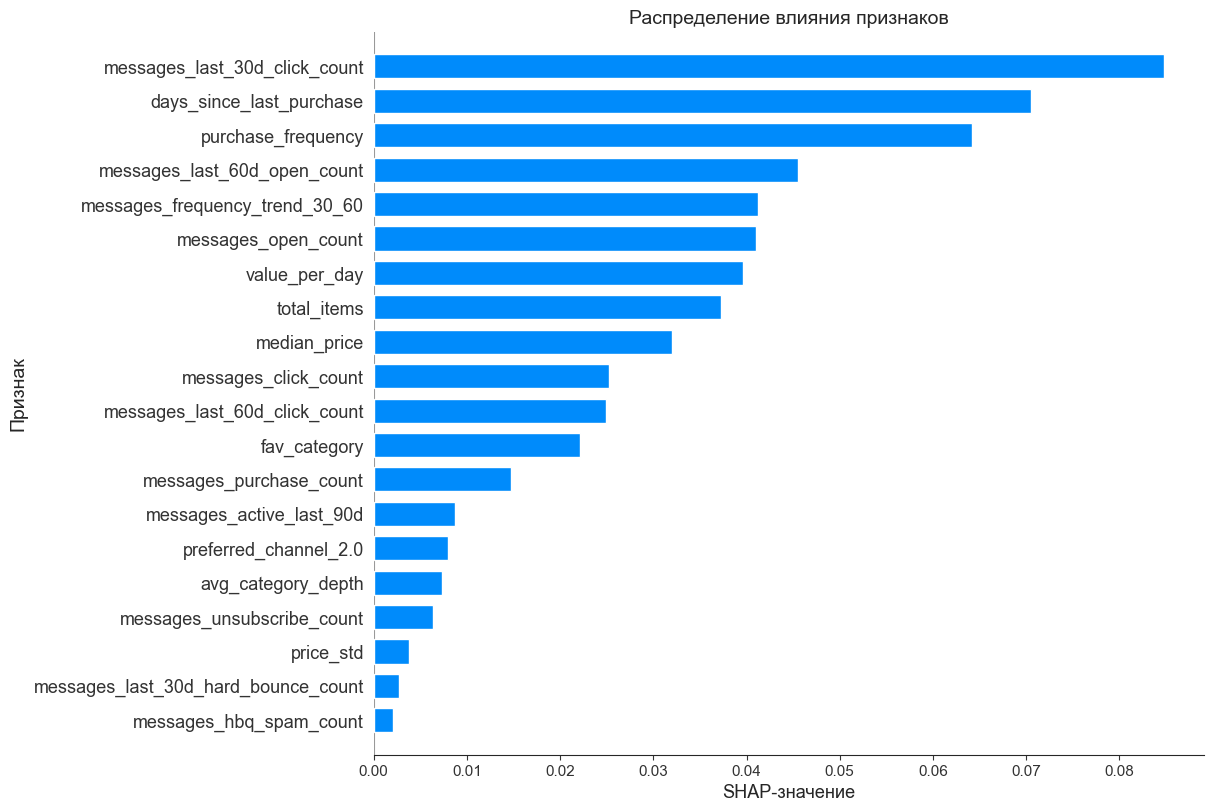

In [2757]:
shap_summary_plot()

In [2758]:
# Метод для расчета метрик и построения матрицы ошибок.
def calc_metric_reg(y_test, y_pred):

    # Расчитаем и выведем метрики.
    calc_metric(y_test, y_pred, y_pred)

    # Построим матрицу ошибок методом from_estimator().
    sns.set_style('ticks')
    sns.heatmap(
        confusion_matrix(y_test, y_pred), 
        annot=True, 
        fmt='0', 
        cmap= 'coolwarm',
        linewidths=0.5,
        annot_kws={'size':str(12)},
        linecolor='black'
        )
    plt.title('Матрица ошибок', size=16)
    plt.ylabel('Истина')
    plt.xlabel('Прогноз')
    plt.show()

Метрика roc_auc на тестовой выборке: 0.689
Метрика f1 на тестовой выборке: 0.085
Метрика accuracy_score на тестовой выборке: 0.735
Метрика precision на тестовой выборке: 0.046
Метрика recall на тестовой выборке: 0.642


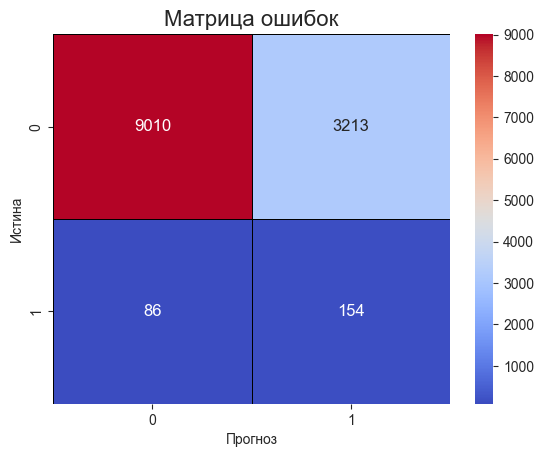

In [2759]:
calc_metric_reg(y_test, y_test_pred)

📊 Общая оценка результатов

Модель продемонстрировала умеренное качество с ROC-AUC = 0.689, что указывает на способность различать классы выше случайного уровня (0.5).<br/>
Есть значительный потенциал для улучшения.

🎯 Анализ метрик:

- ROC-AUC: 0.689 - модель обладает предсказательной способностью, но требует оптимизации
- F1: 0.085 - низкий баланс между precision и recall
- Accuracy: 0.735 - обманчиво высокий из-за дисбаланса классов
- Precision: 0.046 - только 4.6% предсказанных покупок действительно состоялись
- Recall: 0.642 - модель находит 64.2% реальных покупателей<br/>

⚖️ Анализ ошибок:

- False Negative (86) - пропущенные покупатели (потерянная выручка)
- False Positive (3213) - ложные срабатывания (напрасно потраченные маркетинговые ресурсы)
- True Positive (154) - правильно идентифицированные покупатели
- True Negative (9010) - правильно отвергнутые не-покупатели<br/>

📈 Сильные стороны:

- Хороший recall (64.2%) - модель находит большинство реальных покупателей
- ROC-AUC выше базового уровня
- Высокий True Negative rate - эффективно отсеивает неактивных пользователей<br/>

📉 Слабые стороны:

- Крайне низкий precision - много ложных срабатываний
- Сильное влияние дисбаланса классов (2% positive)
- Высокий уровень False Positive<br/>

🎯 Рекомендации по улучшению:

- Оптимизация порога классификации
- Добавление временных трендов
- Более детальная категоризация
- Внешние данные (сезонность, праздники)
- Оптимизация модели. Подбор гиперпараметров.<br/>

💼 Бизнес-интерпретация:

Модель может быть полезна для первоначального скрининга, но требует ручной верификации предсказаний из-за низкого precision.<br/>
Подходит для задач, где важнее найти больше покупателей (высокий recall), даже с риском ложных срабатываний.<br/>

Текущая модель:

Находит 64.2% покупателей.<br/>
Результат является хорошим базовым уровнем для дальнейших экспериментов и оптимизаций.